In [1]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')

import sys
sys.path.append('..')
import plotconfig

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [3]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal"))

df = df[mask]
df['method_name'].unique()

array(['LinearRegression', 'Shuffle_LinearRegression',
       'DummyScoring_Mean', 'SVR', 'MLP'], dtype=object)

In [4]:
df.keys()

Index(['method_name', 'training_size', 'eeg_name', 'test_name', 'fit_time',
       'source_id', 'raw_scores', 'shuffled_scores', 'target_raw_score',
       'target_shuffled_score', 'scores', 'true_distances', 'raw_scores_std',
       'shuffled_scores_std', 'scores_std', 'euclidean_at_top_rank',
       'pearsonr_statistic', 'pearsonr_pvalue', 'spearmanr_statistic',
       'spearmanr_pvalue', 'target_rank', 'top_1_accuracy',
       'min_euclidean_top_1', 'top_3_accuracy', 'min_euclidean_top_3',
       'top_5_accuracy', 'min_euclidean_top_5', 'top_10_accuracy',
       'min_euclidean_top_10', 'range_to_noise_ratio', 'snr_classic',
       'snr_power', 'signal_to_uncertainty_ratio', 'rmse_true_vs_estimated'],
      dtype='object')

In [5]:
columns_to_clean = ['range_to_noise_ratio', 'snr_classic', 'snr_power', 'signal_to_uncertainty_ratio']

for col in columns_to_clean:
    if col in df.columns:
        # Replace inf values with 0
        df[col] = df[col].replace([np.inf, -np.inf], 0)
        # Also replace any NaN values that might exist
        df[col] = df[col].fillna(0)
        print(f"Cleaned {col}")
    else:
        print(f"Skipped {col} (column not found)")

Cleaned range_to_noise_ratio
Cleaned snr_classic
Cleaned snr_power
Cleaned signal_to_uncertainty_ratio


['LinearRegression', 'Shuffle_LinearRegression', 'DummyScoring_Mean', 'SVR', 'MLP']
['Linear Regression', 'Shuffle Linear Regression', 'Mean Dummy Regressor', 'SVR', 'MLP']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


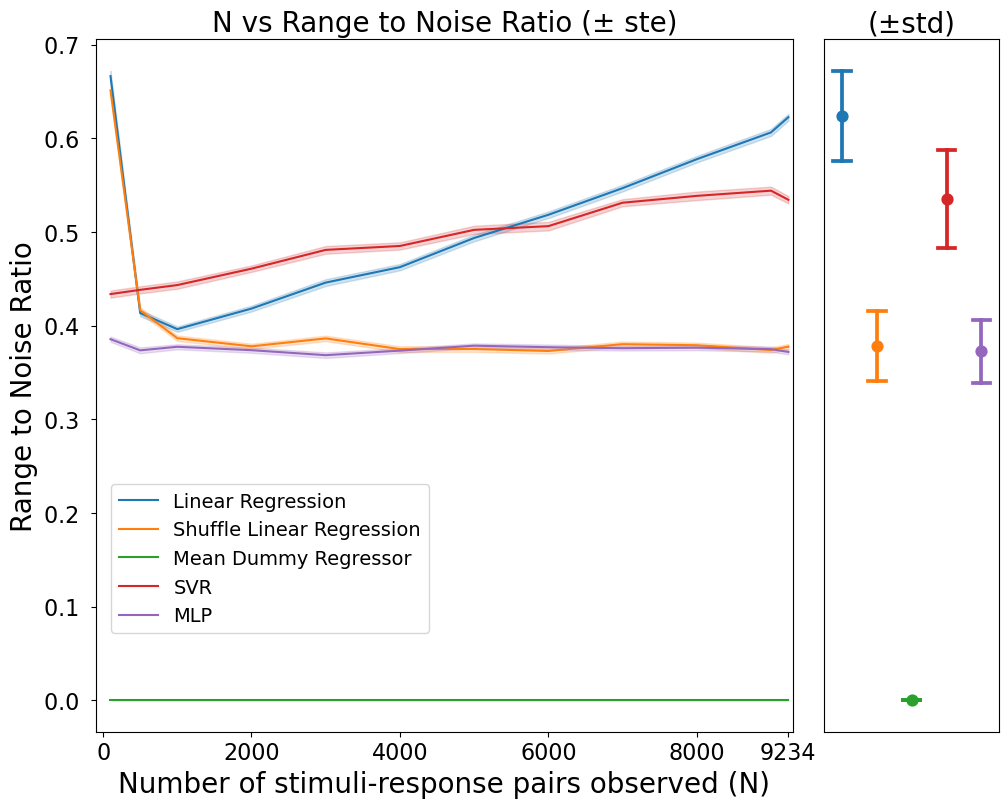

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(10, 8), 
                               gridspec_kw={'width_ratios': [4, 1]})

metric_name = 'signal_to_uncertainty_ratio'

sns.lineplot(data=df, 
             x='training_size', 
             y=metric_name, 
             hue='method_name', 
             errorbar=('se', 1),
             ax=ax1)


# Clear the existing legend
ax1.get_legend().remove()
# Create a new legend with custom labels and position
handles, labels = ax1.get_legend_handles_labels()
print(labels)
# new_labels = ['Linear Regression', 'Shuffle Linear Regression', 'Dummy Regressor (Mean)', 'Theoretical Random Retrieval']  # Replace with your desired labels
new_labels = ['Linear Regression', 'Shuffle Linear Regression', 'Mean Dummy Regressor', 'SVR', 'MLP']  # Replace with your desired labels
print(new_labels)
ax1.legend(handles, new_labels, 
           bbox_to_anchor=(0.25, 0.25),  # x, y coordinates inside the plot
           loc='center',               # Center the legend box at the specified coordinates
           # title_fontsize=14,
           fontsize=plotconfig.LEGEND_FONTSIZE)

ax1.set_title("N vs Range to Noise Ratio (± ste)", fontsize=plotconfig.LABEL_FONTSIZE)
ax1.set_xlabel("Number of stimuli-response pairs observed (N)", fontsize=plotconfig.LABEL_FONTSIZE)
ax1.set_ylabel("Range to Noise Ratio", fontsize=plotconfig.LABEL_FONTSIZE)

current_xticks = ax1.get_xticks()
new_xticks = np.sort(np.append(current_xticks, np.max(df['training_size'])
))
ax1.set_xticks(new_xticks)


def custom_formatter(x, pos):
    if np.isclose(x, -0.773, rtol=1e-03, atol=1e-03):
        return f"{x:.2f}"
    else:
        return f"{x:.1f} "

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

ax1.tick_params(axis='x', labelsize=plotconfig.TICK_SIZE)
ax1.tick_params(axis='y', labelsize=plotconfig.TICK_SIZE)

# ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
# plt.gca().xaxis.set_major_locator(plt.AutoLocator())
# ylim = [-0.1, 3]
ax1.set_xlim(-100, 9300)  # Set x-axis limits from 0 to 60
# ax1.set_ylim(ylim)  # Set y-axis limits from 0 to 10
# ax1.invert_yaxis()

df_last = df[df['training_size'] == plotconfig.LAST_N]

sns.pointplot(x='method_name', y=metric_name, hue='method_name', data=df_last, 
              capsize=0.5, linestyle='none', errorbar='sd')

ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('(±std)', fontsize=plotconfig.LABEL_FONTSIZE)
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove y-ticks and labels
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)  # Remove y-ticks and labels

# ax2.set_ylim(ylim)  # Set y-axis limits from 0 to 10
# ax2.invert_yaxis()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plotconfig.save_fig(metric_name)

In [7]:
a = df[df['method_name'] == 'LinearRegression']
a = a[a['training_size'] == 9234]
m = []
for i in range(a.shape[0]):
    m.append(a.iloc[i]['target_rank'])

# Quick hack to calculate top-k accuracy
ranks = np.array(m)
for k in [1, 3, 5, 10]:
    top_k_acc = np.mean(ranks <= k)
    print(f'Top-{k} accuracy: {top_k_acc:.3f}')
    
# Initialize storage for all k values
results = {}
for k in [1, 3, 5, 10]:
   results[f'min_euclidean_top_{k}'] = []

# Collect min euclidean for each row and each k
for i in range(a.shape[0]):
   for k in [1, 3, 5, 10]:
        scores_sorted_indexes = np.flip(np.argsort(a.iloc[i]['scores']))
        min_euclidean_top_k = np.min(a.iloc[i]['true_distances'][scores_sorted_indexes[:k]])
        results[f'min_euclidean_top_{k}'].append(min_euclidean_top_k)

# Calculate and print average and std for each k
for k in [1, 3, 5, 10]:
   values = np.array(results[f'min_euclidean_top_{k}'])
   avg = np.mean(values)
   std = np.std(values)
   print(f'Top-{k} min euclidean - Avg: {avg:.4f}, Std: {std:.4f}')

Top-1 accuracy: 0.106
Top-3 accuracy: 0.212
Top-5 accuracy: 0.312
Top-10 accuracy: 0.612
Top-1 min euclidean - Avg: 1.6718, Std: 1.6070
Top-3 min euclidean - Avg: 0.6975, Std: 0.6610
Top-5 min euclidean - Avg: 0.4113, Std: 0.4134
Top-10 min euclidean - Avg: 0.1571, Std: 0.2527


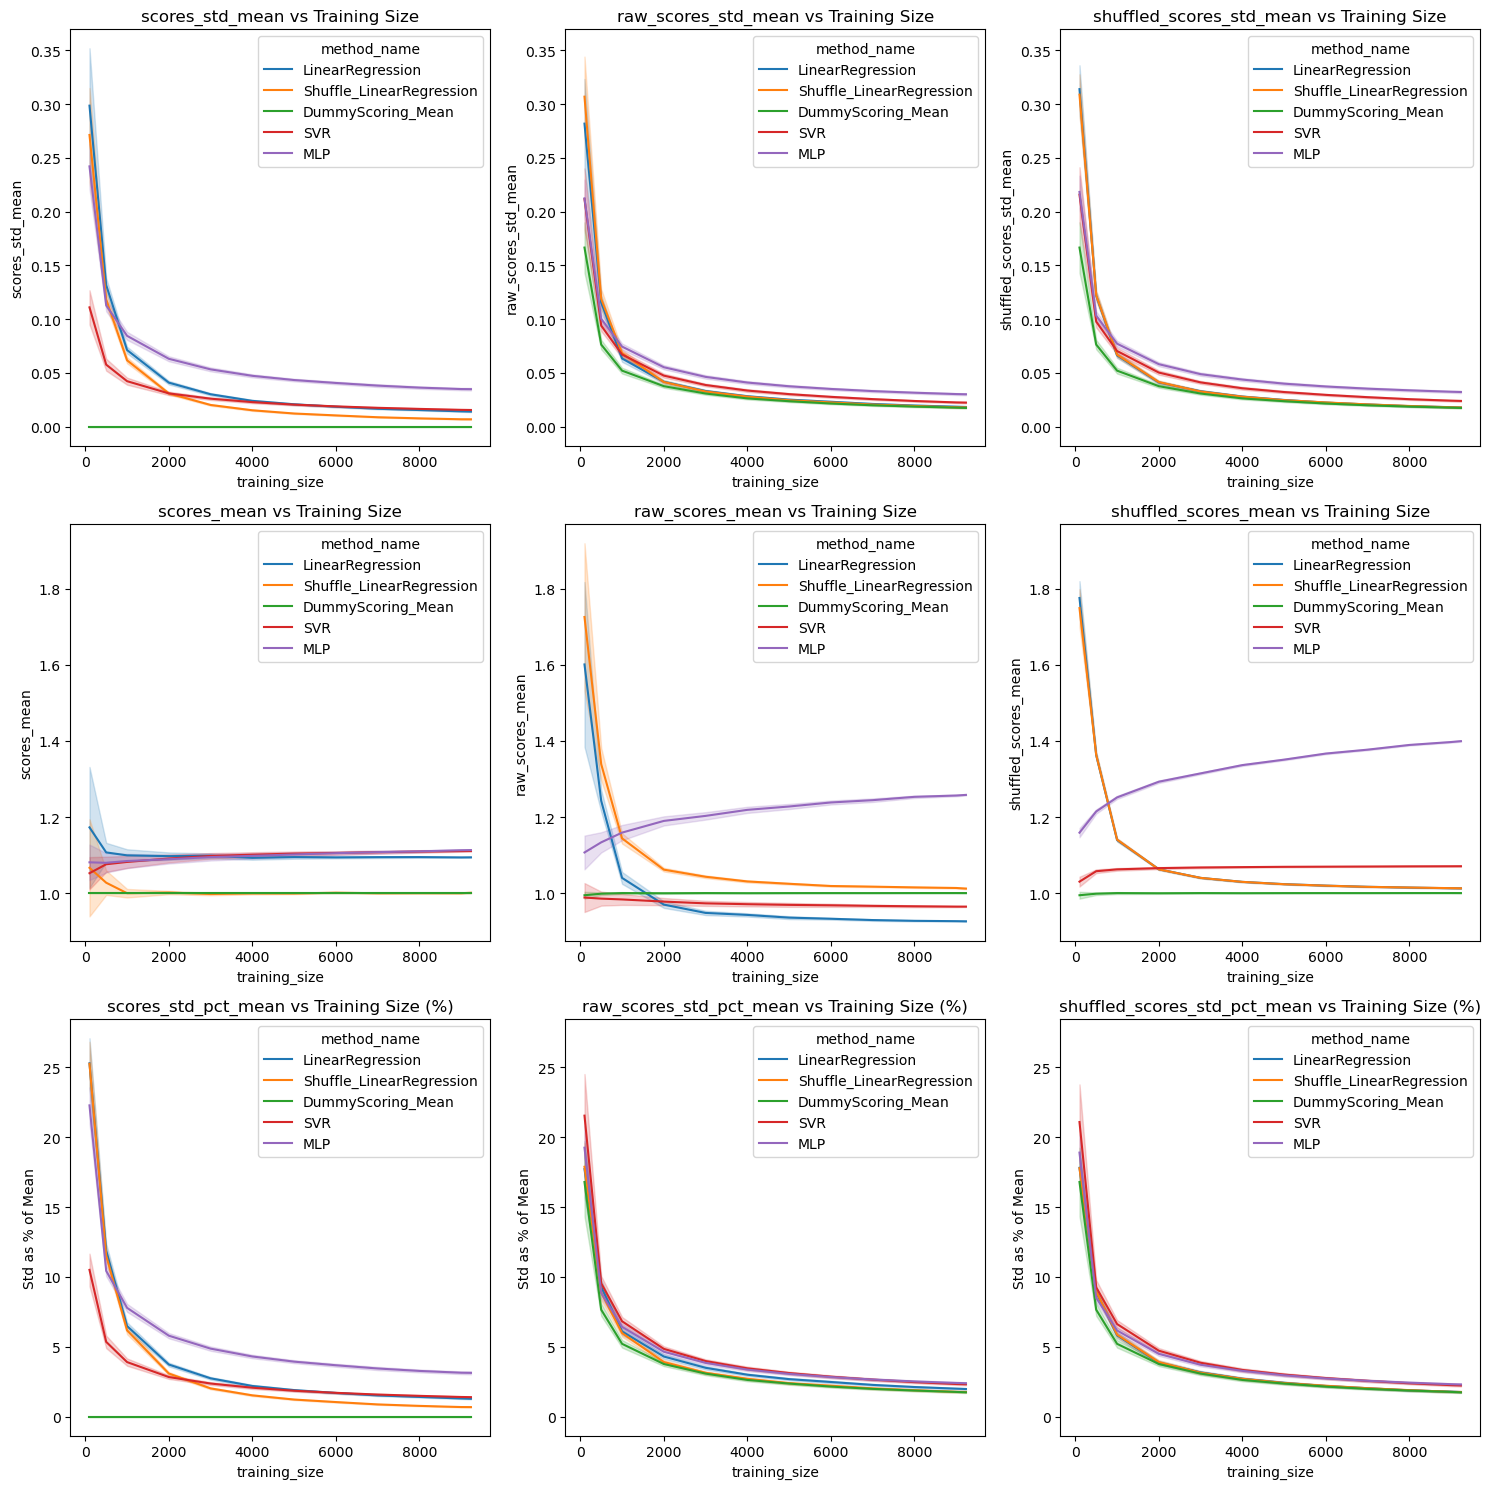

In [8]:
# Calculate means for all metrics
df['scores_std_mean'] = df['scores_std'].apply(lambda x: np.mean(x))
df['raw_scores_std_mean'] = df['raw_scores_std'].apply(lambda x: np.mean(x))
df['shuffled_scores_std_mean'] = df['shuffled_scores_std'].apply(lambda x: np.mean(x))

df['scores_mean'] = df['scores'].apply(lambda x: np.mean(x))
df['raw_scores_mean'] = df['raw_scores'].apply(lambda x: np.mean(x))
df['shuffled_scores_mean'] = df['shuffled_scores'].apply(lambda x: np.mean(x))

# Calculate std as percentage on a per-element basis
df['scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['scores_std'], row['scores'])], axis=1)
df['raw_scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['raw_scores_std'], row['raw_scores'])], axis=1)
df['shuffled_scores_std_pct'] = df.apply(lambda row: [(std/score)*100 for std, score in zip(row['shuffled_scores_std'], row['shuffled_scores'])], axis=1)

# Calculate mean of the percentage lists for plotting
df['scores_std_pct_mean'] = df['scores_std_pct'].apply(lambda x: np.mean(x))
df['raw_scores_std_pct_mean'] = df['raw_scores_std_pct'].apply(lambda x: np.mean(x))
df['shuffled_scores_std_pct_mean'] = df['shuffled_scores_std_pct'].apply(lambda x: np.mean(x))

# List of all mean metrics to plot (using the mean versions of the percentage columns)
mean_metrics = ['scores_std_mean', 'raw_scores_std_mean', 'shuffled_scores_std_mean', 
                'scores_mean', 'raw_scores_mean', 'shuffled_scores_mean',
                'scores_std_pct_mean', 'raw_scores_std_pct_mean', 'shuffled_scores_std_pct_mean']

# Create subplots (3 rows now)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Store y-limits for each row
row_ylims = [[], [], []]

for i, metric_name in enumerate(mean_metrics):
    sns.lineplot(data=df, 
                 x='training_size', 
                 y=metric_name, 
                 hue='method_name', 
                 errorbar=('sd', 1),
                 ax=axes[i])
    
    # Set title to identify the metric
    if 'std_pct' in metric_name:
        axes[i].set_title(f'{metric_name} vs Training Size (%)')
        axes[i].set_ylabel('Std as % of Mean')
    else:
        axes[i].set_title(f'{metric_name} vs Training Size')
    
    # Store y-limits for each row
    row_idx = i // 3  # 0 for first row, 1 for second row, 2 for third row
    row_ylims[row_idx].extend(axes[i].get_ylim())

# Set shared y-limits for each row
for row in range(3):
    y_min = min(row_ylims[row][::2])  # Min values (every other element)
    y_max = max(row_ylims[row][1::2])  # Max values (every other element)
    
    for col in range(3):
        axes[row * 3 + col].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [9]:
df_exploded['training_size'].unique()

NameError: name 'df_exploded' is not defined

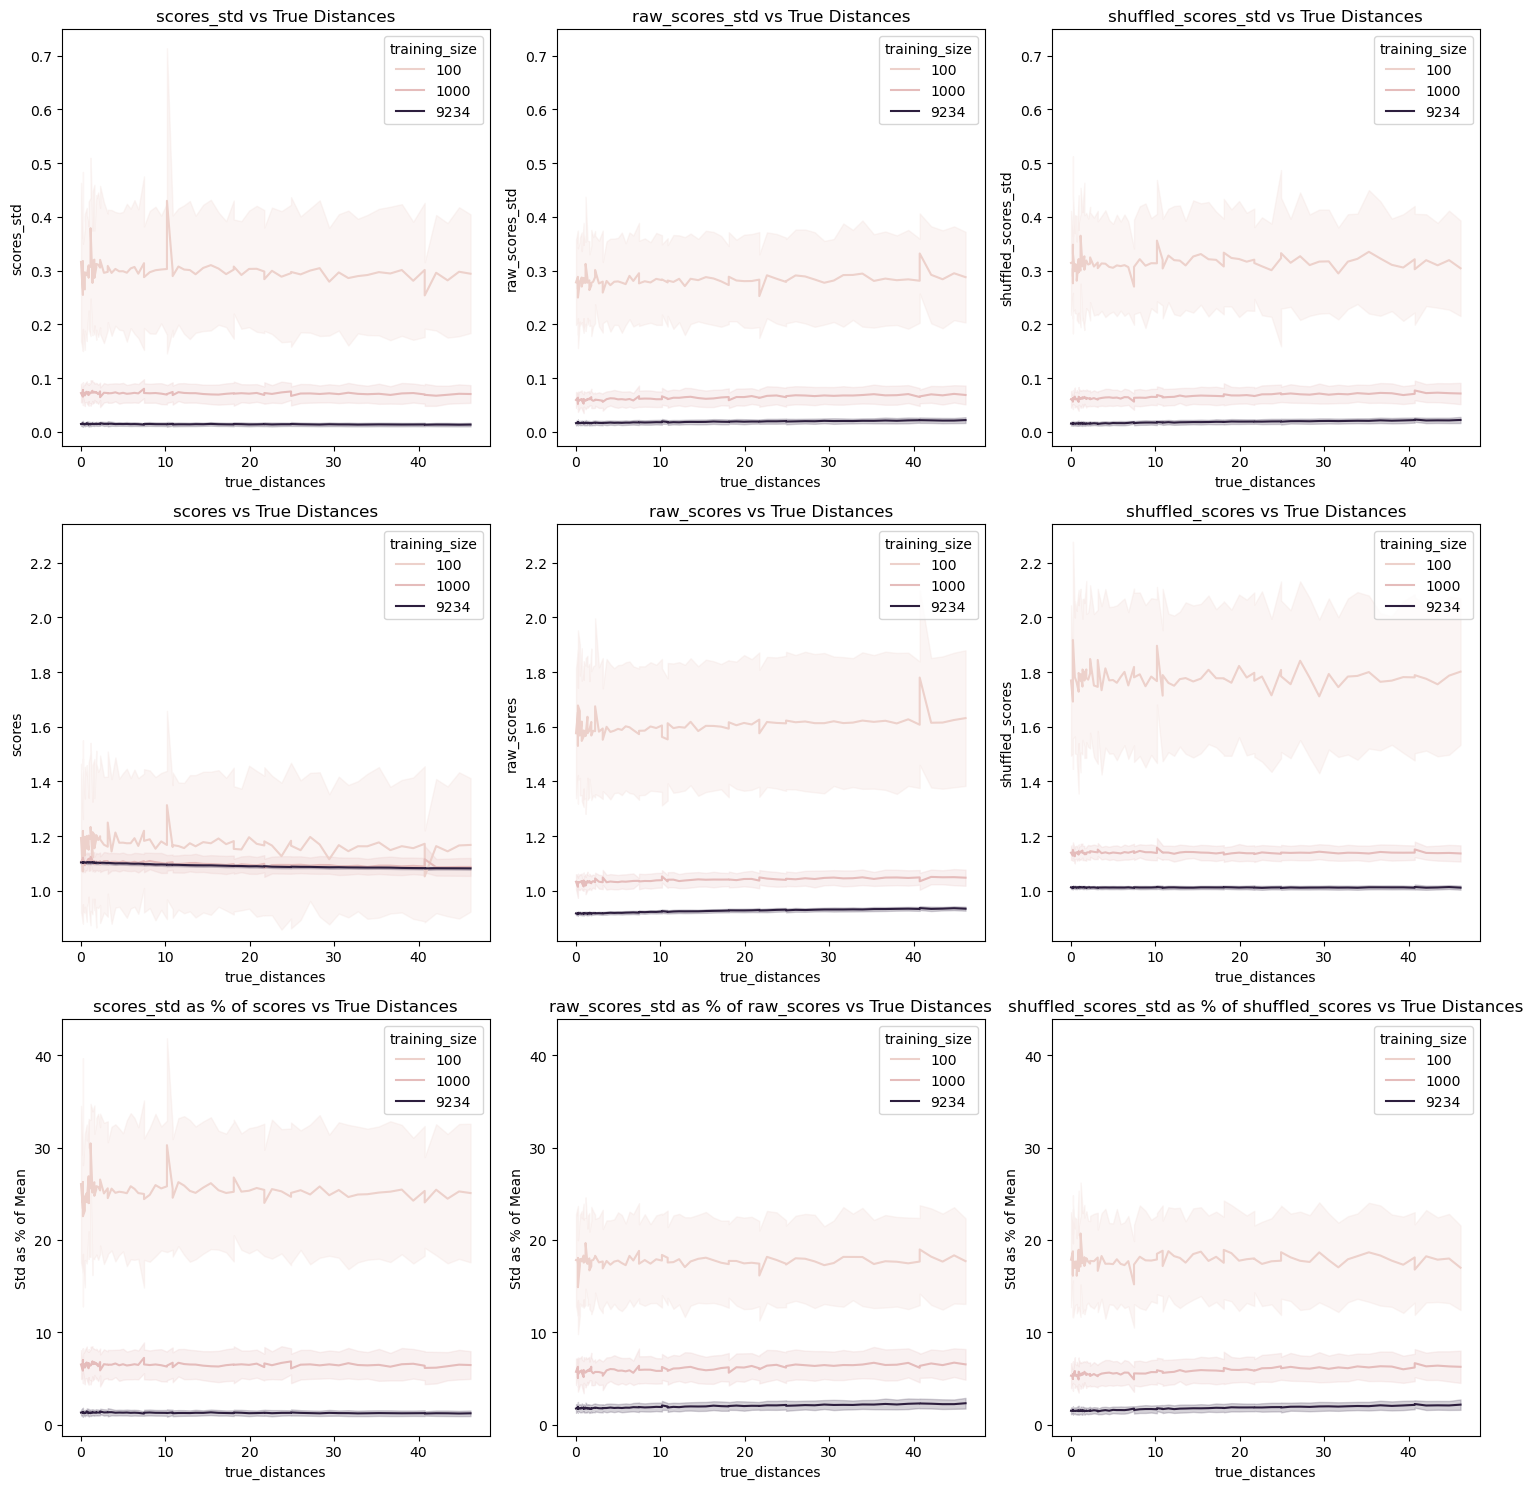

In [ ]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal") &
        (df['method_name'] == 'LinearRegression'))

df = df[mask]

# List of all metrics to plot
metrics = ['scores_std', 'raw_scores_std', 'shuffled_scores_std', 'scores', 'raw_scores', 'shuffled_scores']

# Filter for specific training sizes
df_filtered = df[df['training_size'].isin([100, 1000, 9234])]

# Create subplots - adjust rows and cols as needed (3 rows now for std, values, and percentages)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Store y-limits for each row
row_ylims = [[], [], []]

for i, metric_name in enumerate(metrics):
    # Create a flattened version of your data
    df_exploded = df_filtered.explode(['true_distances', metric_name])

    # Convert to numeric if they're strings
    df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
    df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])

    sns.lineplot(data=df_exploded, 
                 x='true_distances', 
                 y=metric_name, 
                 hue='training_size', 
                 errorbar=('sd', 1),
                 ax=axes[i])

    # Force all unique values in legend
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, title='training_size')
    
    # Set title to identify the metric
    axes[i].set_title(f'{metric_name} vs True Distances')
    
    # Store y-limits for each row
    row_idx = i // 3  # 0 for first row, 1 for second row, 2 for third row
    row_ylims[row_idx].extend(axes[i].get_ylim())

# Now add the percentage plots for std metrics
std_metrics = ['scores_std', 'raw_scores_std', 'shuffled_scores_std']
base_metrics = ['scores', 'raw_scores', 'shuffled_scores']

for i, (std_metric, base_metric) in enumerate(zip(std_metrics, base_metrics)):
    # Create exploded data for both std and base metrics
    df_exploded = df_filtered.explode(['true_distances', std_metric, base_metric])
    
    # Convert to numeric
    df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
    df_exploded[std_metric] = pd.to_numeric(df_exploded[std_metric])
    df_exploded[base_metric] = pd.to_numeric(df_exploded[base_metric])
    
    # Calculate percentage
    df_exploded['pct'] = (df_exploded[std_metric] / df_exploded[base_metric]) * 100
    
    sns.lineplot(data=df_exploded, 
                 x='true_distances', 
                 y='pct', 
                 hue='training_size', 
                 errorbar=('sd', 1),
                 ax=axes[i + 6])  # Start from index 6 for third row

    # Force all unique values in legend
    handles, labels = axes[i + 6].get_legend_handles_labels()
    axes[i + 6].legend(handles, labels, title='training_size')
    
    # Set title and labels
    axes[i + 6].set_title(f'{std_metric} as % of {base_metric} vs True Distances')
    axes[i + 6].set_ylabel('Std as % of Mean')
    
    # Store y-limits for third row
    row_ylims[2].extend(axes[i + 6].get_ylim())

# Set shared y-limits for each row
for row in range(3):
    y_min = min(row_ylims[row][::2])  # Min values (every other element)
    y_max = max(row_ylims[row][1::2])  # Max values (every other element)
    
    for col in range(3):
        axes[row * 3 + col].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

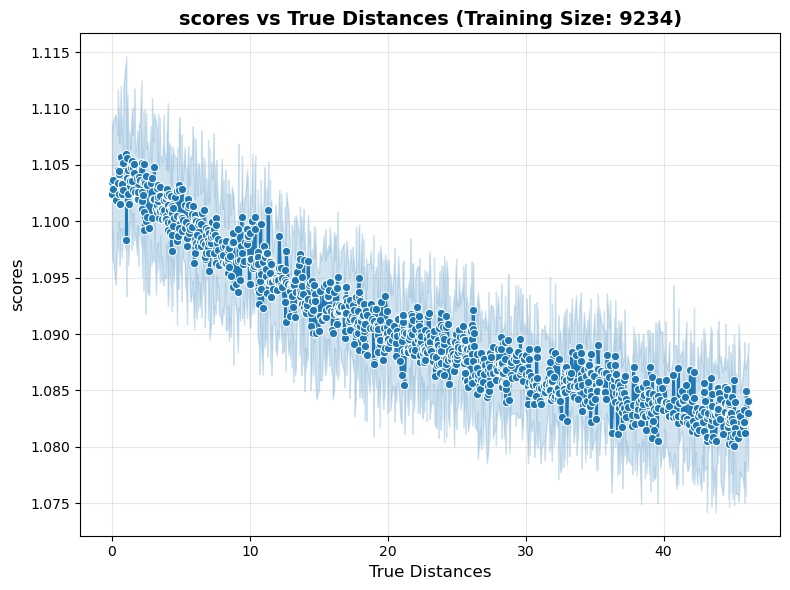

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random") &
        (df['method_name'] == 'LinearRegression'))

df = df[mask]

# Filter for only training_size 9234
df_filtered = df[df['training_size'] == 9234]

# Focus on scores metric (column 1, row 2 from your original plot)
metric_name = 'scores'

# Create a single plot
plt.figure(figsize=(8, 6))

# Create exploded data
df_exploded = df_filtered.explode(['true_distances', metric_name])

# Convert to numeric
df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])

# Create the line plot
sns.lineplot(data=df_exploded, 
             x='true_distances', 
             y=metric_name, 
             errorbar=('sd', 1),
             marker='o',
             linewidth=2)

# Set title and labels
plt.title(f'{metric_name} vs True Distances (Training Size: 9234)', fontsize=14, fontweight='bold')
plt.xlabel('True Distances', fontsize=12)
plt.ylabel(metric_name, fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== STATISTICAL ANALYSIS OF SLOPE CONFIDENCE ===

1. LINEAR REGRESSION ANALYSIS
----------------------------------------
Slope: -0.00045900
Intercept: 1.101072
R-squared: 0.897556

2. CORRELATION ANALYSIS
----------------------------------------
Pearson correlation: -0.947415
P-value: 0.00e+00
Spearman correlation: -0.961995
Spearman P-value: 0.00e+00

3. SLOPE SIGNIFICANCE TEST
----------------------------------------
Standard error of slope: 0.00000493
T-statistic: -93.1405
P-value for slope: 0.00e+00
95% CI for slope: [-0.00046867, -0.00044933]

4. SIGNAL-TO-NOISE ANALYSIS
----------------------------------------
Signal range: 0.025881
Mean noise (std): 0.013827
Signal-to-Noise Ratio: 1.8718

5. EFFECT SIZE ANALYSIS
----------------------------------------
Cohen's d (low vs high distances): -10.4639
Effect size interpretation: large

6. TREND MEANINGFULNESS ASSESSMENT
----------------------------------------
Trend is monotonic: False
Percentage of variance explained by distance: 89.

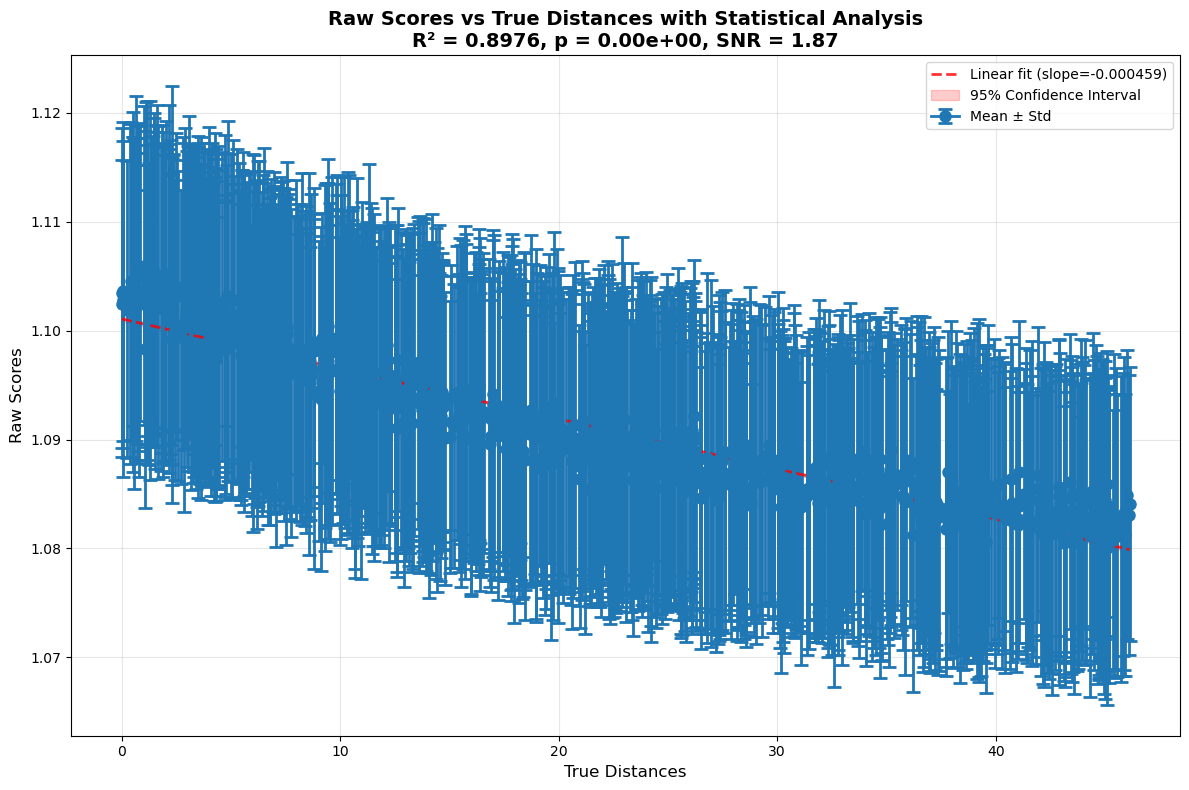


Key Statistics Summary:
• Correlation: -0.9474 (p = 0.00e+00)
• R-squared: 0.8976
• Signal-to-Noise Ratio: 1.87
• Slope 95% CI: [-0.000469, -0.000449]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random") &
        (df['method_name'] == 'LinearRegression'))

df = df[mask]
df_filtered = df[df['training_size'] == 9234]

# Create exploded data
df_exploded = df_filtered.explode(['true_distances', 'scores', 'scores_std'])
df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
df_exploded['scores'] = pd.to_numeric(df_exploded['scores'])
df_exploded['scores_std'] = pd.to_numeric(df_exploded['scores_std'])

# Calculate aggregate statistics per true_distance
agg_stats = df_exploded.groupby('true_distances').agg({
    'scores': ['mean', 'std', 'count'],
    'scores_std': 'mean'
}).round(6)

# Flatten column names
agg_stats.columns = ['mean_score', 'std_score', 'n_obs', 'mean_std']
agg_stats = agg_stats.reset_index()

print("=== STATISTICAL ANALYSIS OF SLOPE CONFIDENCE ===\n")

# 1. LINEAR REGRESSION WITH CONFIDENCE INTERVALS
print("1. LINEAR REGRESSION ANALYSIS")
print("-" * 40)

X = agg_stats['true_distances'].values.reshape(-1, 1)
y = agg_stats['mean_score'].values
weights = 1 / agg_stats['mean_std']  # Weight by inverse of std

# Fit linear regression
reg = LinearRegression().fit(X, y, sample_weight=weights)
slope = reg.coef_[0]
intercept = reg.intercept_

# Calculate R-squared
y_pred = reg.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Slope: {slope:.8f}")
print(f"Intercept: {intercept:.6f}")
print(f"R-squared: {r_squared:.6f}")

# 2. CORRELATION ANALYSIS
print("\n2. CORRELATION ANALYSIS")
print("-" * 40)

# Pearson correlation
corr_coef, p_value = stats.pearsonr(agg_stats['true_distances'], agg_stats['mean_score'])
print(f"Pearson correlation: {corr_coef:.6f}")
print(f"P-value: {p_value:.2e}")

# Spearman correlation (non-parametric)
spearman_coef, spearman_p = stats.spearmanr(agg_stats['true_distances'], agg_stats['mean_score'])
print(f"Spearman correlation: {spearman_coef:.6f}")
print(f"Spearman P-value: {spearman_p:.2e}")

# 3. SLOPE SIGNIFICANCE TEST
print("\n3. SLOPE SIGNIFICANCE TEST")
print("-" * 40)

# Calculate standard error of slope
n = len(agg_stats)
x_mean = np.mean(agg_stats['true_distances'])
ss_x = np.sum((agg_stats['true_distances'] - x_mean) ** 2)
mse = ss_res / (n - 2)  # Mean squared error
se_slope = np.sqrt(mse / ss_x)

# T-statistic and p-value for slope
t_stat = slope / se_slope
t_p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))

print(f"Standard error of slope: {se_slope:.8f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value for slope: {t_p_value:.2e}")

# 95% confidence interval for slope
t_critical = stats.t.ppf(0.975, n - 2)
slope_ci_lower = slope - t_critical * se_slope
slope_ci_upper = slope + t_critical * se_slope

print(f"95% CI for slope: [{slope_ci_lower:.8f}, {slope_ci_upper:.8f}]")

# 4. SIGNAL-TO-NOISE ANALYSIS
print("\n4. SIGNAL-TO-NOISE ANALYSIS")
print("-" * 40)

# Range of the signal (difference between max and min means)
signal_range = agg_stats['mean_score'].max() - agg_stats['mean_score'].min()
mean_noise = agg_stats['mean_std'].mean()

snr = signal_range / mean_noise
print(f"Signal range: {signal_range:.6f}")
print(f"Mean noise (std): {mean_noise:.6f}")
print(f"Signal-to-Noise Ratio: {snr:.4f}")

# 5. EFFECT SIZE ANALYSIS
print("\n5. EFFECT SIZE ANALYSIS")
print("-" * 40)

# Cohen's d for the difference between lowest and highest distance groups
low_distances = agg_stats[agg_stats['true_distances'] <= 5]['mean_score']
high_distances = agg_stats[agg_stats['true_distances'] >= 35]['mean_score']

if len(low_distances) > 0 and len(high_distances) > 0:
    pooled_std = np.sqrt(((len(low_distances) - 1) * low_distances.std()**2 + 
                         (len(high_distances) - 1) * high_distances.std()**2) / 
                        (len(low_distances) + len(high_distances) - 2))
    cohens_d = (high_distances.mean() - low_distances.mean()) / pooled_std
    print(f"Cohen's d (low vs high distances): {cohens_d:.4f}")
    
    # Interpret Cohen's d
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    print(f"Effect size interpretation: {effect_size}")

# 6. TREND ANALYSIS WITH CONFIDENCE BANDS
print("\n6. TREND MEANINGFULNESS ASSESSMENT")
print("-" * 40)

# Check if trend is monotonic
is_monotonic = all(agg_stats['mean_score'].iloc[i] <= agg_stats['mean_score'].iloc[i+1] 
                   for i in range(len(agg_stats)-1))
print(f"Trend is monotonic: {is_monotonic}")

# Calculate percentage of variance explained by distance
percent_variance_explained = r_squared * 100
print(f"Percentage of variance explained by distance: {percent_variance_explained:.2f}%")

# Final assessment
print("\n" + "="*60)
print("FINAL ASSESSMENT")
print("="*60)

confidence_level = "HIGH" if (p_value < 0.01 and snr > 2 and r_squared > 0.8) else \
                  "MODERATE" if (p_value < 0.05 and snr > 1 and r_squared > 0.5) else \
                  "LOW"

print(f"Statistical Confidence in Slope: {confidence_level}")
print(f"The trend is {'MEANINGFUL' if confidence_level in ['HIGH', 'MODERATE'] else 'QUESTIONABLE'}")

if confidence_level == "HIGH":
    print("✓ Strong evidence that ranking scores are meaningful")
elif confidence_level == "MODERATE":
    print("± Moderate evidence that ranking scores are meaningful")
else:
    print("✗ Weak evidence that ranking scores are meaningful")

# Create enhanced visualization
plt.figure(figsize=(12, 8))

# Plot with confidence intervals
plt.errorbar(agg_stats['true_distances'], agg_stats['mean_score'], 
             yerr=agg_stats['mean_std'], fmt='o-', capsize=5, capthick=2,
             linewidth=2, markersize=8, label='Mean ± Std')

# Add regression line
x_line = np.linspace(agg_stats['true_distances'].min(), agg_stats['true_distances'].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.8, 
         label=f'Linear fit (slope={slope:.6f})')

# Add confidence interval for regression
se_pred = np.sqrt(mse * (1/n + (x_line - x_mean)**2 / ss_x))
ci_lower = y_line - t_critical * se_pred
ci_upper = y_line + t_critical * se_pred
plt.fill_between(x_line, ci_lower, ci_upper, alpha=0.2, color='red', 
                 label='95% Confidence Interval')

plt.xlabel('True Distances', fontsize=12)
plt.ylabel('Raw Scores', fontsize=12)
plt.title(f'Raw Scores vs True Distances with Statistical Analysis\n' +
          f'R² = {r_squared:.4f}, p = {p_value:.2e}, SNR = {snr:.2f}', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKey Statistics Summary:")
print(f"• Correlation: {corr_coef:.4f} (p = {p_value:.2e})")
print(f"• R-squared: {r_squared:.4f}")
print(f"• Signal-to-Noise Ratio: {snr:.2f}")
print(f"• Slope 95% CI: [{slope_ci_lower:.6f}, {slope_ci_upper:.6f}]")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random") &
        (df['method_name'] == 'LinearRegression'))

df = df[mask]

def calculate_key_statistics(df_subset):
    """Calculate the key statistics for a given subset of data"""
    
    # Create exploded data
    df_exploded = df_subset.explode(['true_distances', 'scores', 'scores_std'])
    df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
    df_exploded['scores'] = pd.to_numeric(df_exploded['scores'])
    df_exploded['scores_std'] = pd.to_numeric(df_exploded['scores_std'])
    
    # Calculate aggregate statistics per true_distance
    agg_stats = df_exploded.groupby('true_distances').agg({
        'scores': ['mean', 'std', 'count'],
        'scores_std': 'mean'
    }).round(6)
    
    # Flatten column names
    agg_stats.columns = ['mean_score', 'std_score', 'n_obs', 'mean_std']
    agg_stats = agg_stats.reset_index()
    
    # Linear regression with weights
    X = agg_stats['true_distances'].values.reshape(-1, 1)
    y = agg_stats['mean_score'].values
    weights = 1 / agg_stats['mean_std']  # Weight by inverse of std
    
    reg = LinearRegression().fit(X, y, sample_weight=weights)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    
    # Calculate R-squared
    y_pred = reg.predict(X)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Correlation analysis
    corr_coef, p_value = stats.pearsonr(agg_stats['true_distances'], agg_stats['mean_score'])
    
    # Slope significance test
    n = len(agg_stats)
    x_mean = np.mean(agg_stats['true_distances'])
    ss_x = np.sum((agg_stats['true_distances'] - x_mean) ** 2)
    mse = ss_res / (n - 2)
    se_slope = np.sqrt(mse / ss_x)
    
    # 95% confidence interval for slope
    t_critical = stats.t.ppf(0.975, n - 2)
    slope_ci_lower = slope - t_critical * se_slope
    slope_ci_upper = slope + t_critical * se_slope
    
    # Signal-to-Noise Ratio
    signal_range = agg_stats['mean_score'].max() - agg_stats['mean_score'].min()
    mean_noise = agg_stats['mean_std'].mean()
    snr = signal_range / mean_noise
    
    return {
        'correlation': corr_coef,
        'p_value': p_value,
        'r_squared': r_squared,
        'snr': snr,
        'slope': slope,
        'slope_ci_lower': slope_ci_lower,
        'slope_ci_upper': slope_ci_upper,
        'n_points': n
    }

# Get all unique training sizes
training_sizes = sorted(df['training_size'].unique())

# Calculate statistics for each training size
results = []

print("KEY STATISTICS FOR ALL TRAINING SIZES")
print("=" * 80)
print(f"{'Training Size':<15} {'Correlation':<12} {'P-value':<12} {'R-squared':<12} {'SNR':<8} {'Slope CI':<25}")
print("-" * 80)

for training_size in training_sizes:
    df_filtered = df[df['training_size'] == training_size]
    
    if len(df_filtered) > 0:
        stats_dict = calculate_key_statistics(df_filtered)
        
        # Store results
        stats_dict['training_size'] = training_size
        results.append(stats_dict)
        
        # Print formatted results
        print(f"{training_size:<15} "
              f"{stats_dict['correlation']:<12.4f} "
              f"{stats_dict['p_value']:<12.2e} "
              f"{stats_dict['r_squared']:<12.4f} "
              f"{stats_dict['snr']:<8.2f} "
              f"[{stats_dict['slope_ci_lower']:.6f}, {stats_dict['slope_ci_upper']:.6f}]")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("SUMMARY STATISTICS ACROSS ALL TRAINING SIZES")
print("=" * 80)

# Summary statistics
print(f"Average Correlation: {results_df['correlation'].mean():.4f} ± {results_df['correlation'].std():.4f}")
print(f"Average R-squared: {results_df['r_squared'].mean():.4f} ± {results_df['r_squared'].std():.4f}")
print(f"Average SNR: {results_df['snr'].mean():.2f} ± {results_df['snr'].std():.2f}")

# Count how many are statistically significant (p < 0.05)
sig_count = (results_df['p_value'] < 0.05).sum()
print(f"\nStatistically significant results (p < 0.05): {sig_count}/{len(results_df)} ({100*sig_count/len(results_df):.1f}%)")

# Count how many have strong correlations (> 0.8)
strong_corr_count = (results_df['correlation'] > 0.8).sum()
print(f"Strong correlations (r > 0.8): {strong_corr_count}/{len(results_df)} ({100*strong_corr_count/len(results_df):.1f}%)")

# Count how many have high R-squared (> 0.8)
high_r2_count = (results_df['r_squared'] > 0.8).sum()
print(f"High R-squared (R² > 0.8): {high_r2_count}/{len(results_df)} ({100*high_r2_count/len(results_df):.1f}%)")

# Best and worst performers
best_corr_idx = results_df['correlation'].idxmax()
worst_corr_idx = results_df['correlation'].idxmin()

print(f"\nBest correlation: Training Size {results_df.loc[best_corr_idx, 'training_size']} (r = {results_df.loc[best_corr_idx, 'correlation']:.4f})")
print(f"Worst correlation: Training Size {results_df.loc[worst_corr_idx, 'training_size']} (r = {results_df.loc[worst_corr_idx, 'correlation']:.4f})")

# Display the results DataFrame
print("\n" + "=" * 80)
print("DETAILED RESULTS TABLE")
print("=" * 80)
print(results_df.round(6).to_string(index=False))

# Export results if needed
print(f"\nResults stored in 'results_df' DataFrame with {len(results_df)} rows and {len(results_df.columns)} columns.")

KEY STATISTICS FOR ALL TRAINING SIZES
Training Size   Correlation  P-value      R-squared    SNR      Slope CI                 
--------------------------------------------------------------------------------
100             -0.1769      1.69e-08     0.0218       2.03     [-0.001731, -0.000824]
500             -0.3094      1.03e-23     0.0952       1.09     [-0.000588, -0.000398]
1000            -0.3967      3.50e-39     0.1573       1.14     [-0.000504, -0.000378]
2000            -0.7215      3.80e-162    0.5204       1.26     [-0.000529, -0.000469]
3000            -0.7737      8.66e-201    0.5985       1.71     [-0.000529, -0.000477]
4000            -0.8372      6.67e-265    0.7009       1.46     [-0.000484, -0.000447]
5000            -0.9005      0.00e+00     0.8108       1.64     [-0.000489, -0.000460]
6000            -0.9207      0.00e+00     0.8478       1.78     [-0.000483, -0.000458]
7000            -0.9210      0.00e+00     0.8483       1.92     [-0.000468, -0.000444]
8000    

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

# Your existing data loading code (without method filtering)
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

# Filter for specific conditions but keep all methods (excluding BestSVR and BestMLP)
mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal"))

df = df[mask]

def calculate_key_statistics(df_subset):
    """Calculate the key statistics for a given subset of data"""
    
    # Create exploded data
    df_exploded = df_subset.explode(['true_distances', 'scores', 'scores_std'])
    df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
    df_exploded['scores'] = pd.to_numeric(df_exploded['scores'])
    df_exploded['scores_std'] = pd.to_numeric(df_exploded['scores_std'])
    
    # Calculate aggregate statistics per true_distance
    agg_stats = df_exploded.groupby('true_distances').agg({
        'scores': ['mean', 'std', 'count'],
        'scores_std': 'mean'
    }).round(6)
    
    # Flatten column names
    agg_stats.columns = ['mean_score', 'std_score', 'n_obs', 'mean_std']
    agg_stats = agg_stats.reset_index()
    
    # Linear regression with weights
    X = agg_stats['true_distances'].values.reshape(-1, 1)
    y = agg_stats['mean_score'].values
    weights = 1 / agg_stats['mean_std']  # Weight by inverse of std
    
    reg = LinearRegression().fit(X, y, sample_weight=weights)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    
    # Calculate R-squared
    y_pred = reg.predict(X)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Correlation analysis
    corr_coef, p_value = stats.pearsonr(agg_stats['true_distances'], agg_stats['mean_score'])
    
    # Slope significance test
    n = len(agg_stats)
    x_mean = np.mean(agg_stats['true_distances'])
    ss_x = np.sum((agg_stats['true_distances'] - x_mean) ** 2)
    mse = ss_res / (n - 2)
    se_slope = np.sqrt(mse / ss_x)
    
    # 95% confidence interval for slope
    t_critical = stats.t.ppf(0.975, n - 2)
    slope_ci_lower = slope - t_critical * se_slope
    slope_ci_upper = slope + t_critical * se_slope
    
    # Signal-to-Noise Ratio
    signal_range = agg_stats['mean_score'].max() - agg_stats['mean_score'].min()
    mean_noise = agg_stats['mean_std'].mean()
    snr = signal_range / mean_noise
    
    return {
        'correlation': corr_coef,
        'p_value': p_value,
        'r_squared': r_squared,
        'snr': snr,
        'slope': slope,
        'slope_ci_lower': slope_ci_lower,
        'slope_ci_upper': slope_ci_upper,
        'n_points': n
    }

# Get all unique method names
method_names = sorted(df['method_name'].unique())

# Calculate statistics for each method
results = []

print("KEY STATISTICS FOR ALL METHOD NAMES")
print("=" * 90)
print(f"{'Method Name':<20} {'Correlation':<12} {'P-value':<12} {'R-squared':<12} {'SNR':<8} {'Slope CI':<25}")
print("-" * 90)

for method_name in method_names:
    df_filtered = df[df['method_name'] == method_name]
    
    if len(df_filtered) > 0:
        try:
            stats_dict = calculate_key_statistics(df_filtered)
            
            # Store results
            stats_dict['method_name'] = method_name
            results.append(stats_dict)
            
            # Print formatted results
            print(f"{method_name:<20} "
                  f"{stats_dict['correlation']:<12.4f} "
                  f"{stats_dict['p_value']:<12.2e} "
                  f"{stats_dict['r_squared']:<12.4f} "
                  f"{stats_dict['snr']:<8.2f} "
                  f"[{stats_dict['slope_ci_lower']:.6f}, {stats_dict['slope_ci_upper']:.6f}]")
        except Exception as e:
            print(f"{method_name:<20} ERROR: {str(e)}")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print("\n" + "=" * 90)
print("SUMMARY STATISTICS ACROSS ALL METHODS")
print("=" * 90)

if len(results_df) > 0:
    # Summary statistics
    print(f"Average Correlation: {results_df['correlation'].mean():.4f} ± {results_df['correlation'].std():.4f}")
    print(f"Average R-squared: {results_df['r_squared'].mean():.4f} ± {results_df['r_squared'].std():.4f}")
    print(f"Average SNR: {results_df['snr'].mean():.2f} ± {results_df['snr'].std():.2f}")

    # Count how many are statistically significant (p < 0.05)
    sig_count = (results_df['p_value'] < 0.05).sum()
    print(f"\nStatistically significant results (p < 0.05): {sig_count}/{len(results_df)} ({100*sig_count/len(results_df):.1f}%)")

    # Count how many have strong correlations (> 0.8)
    strong_corr_count = (results_df['correlation'] > 0.8).sum()
    print(f"Strong correlations (r > 0.8): {strong_corr_count}/{len(results_df)} ({100*strong_corr_count/len(results_df):.1f}%)")

    # Count how many have high R-squared (> 0.8)
    high_r2_count = (results_df['r_squared'] > 0.8).sum()
    print(f"High R-squared (R² > 0.8): {high_r2_count}/{len(results_df)} ({100*high_r2_count/len(results_df):.1f}%)")

    # Best and worst performers
    best_corr_idx = results_df['correlation'].idxmax()
    worst_corr_idx = results_df['correlation'].idxmin()

    print(f"\nBest correlation: {results_df.loc[best_corr_idx, 'method_name']} (r = {results_df.loc[best_corr_idx, 'correlation']:.4f})")
    print(f"Worst correlation: {results_df.loc[worst_corr_idx, 'method_name']} (r = {results_df.loc[worst_corr_idx, 'correlation']:.4f})")

    # Sort by correlation for ranking
    results_df_sorted = results_df.sort_values('correlation', ascending=False)

    # Display the results DataFrame
    print("\n" + "=" * 90)
    print("DETAILED RESULTS TABLE (SORTED BY CORRELATION)")
    print("=" * 90)
    print(results_df_sorted.round(6).to_string(index=False))

    # Export results if needed
    print(f"\nResults stored in 'results_df' DataFrame with {len(results_df)} rows and {len(results_df.columns)} columns.")
    
    # Method performance ranking
    print("\n" + "=" * 90)
    print("METHOD PERFORMANCE RANKING")
    print("=" * 90)
    for i, (_, row) in enumerate(results_df_sorted.iterrows(), 1):
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
        print(f"{i:2d}. {row['method_name']:<20} (r={row['correlation']:.4f}, R²={row['r_squared']:.4f}, SNR={row['snr']:.2f}) {significance}")

else:
    print("No valid results found. Check your data and filtering criteria.")

KEY STATISTICS FOR ALL METHOD NAMES
Method Name          Correlation  P-value      R-squared    SNR      Slope CI                 
------------------------------------------------------------------------------------------
DummyScoring_Mean    ERROR: Input sample_weight contains infinity or a value too large for dtype('float64').
LinearRegression     -0.9258      1.54e-35     0.8570       0.59     [-0.000602, -0.000501]
MLP                  -0.9605      3.27e-46     0.9226       0.26     [-0.000386, -0.000340]
SVR                  -0.9814      4.19e-59     0.9631       0.62     [-0.000455, -0.000417]
Shuffle_LinearRegression 0.0915       4.14e-01     0.0080       0.38     [-0.000021, 0.000054]

SUMMARY STATISTICS ACROSS ALL METHODS
Average Correlation: -0.6941 ± 0.5242
Average R-squared: 0.6877 ± 0.4552
Average SNR: 0.46 ± 0.17

Statistically significant results (p < 0.05): 3/4 (75.0%)
Strong correlations (r > 0.8): 0/4 (0.0%)
High R-squared (R² > 0.8): 3/4 (75.0%)

Best correlation: Sh

Calculating SNR for 'scores' (not raw_scores) for all method-training size combinations...
Successfully calculated SNR for 50 method-training size combinations
Methods included: ['BestMLP', 'BestSVR', 'LinearRegression', 'MLP', 'SVR', 'Shuffle_LinearRegression']
Training sizes included: [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9234]


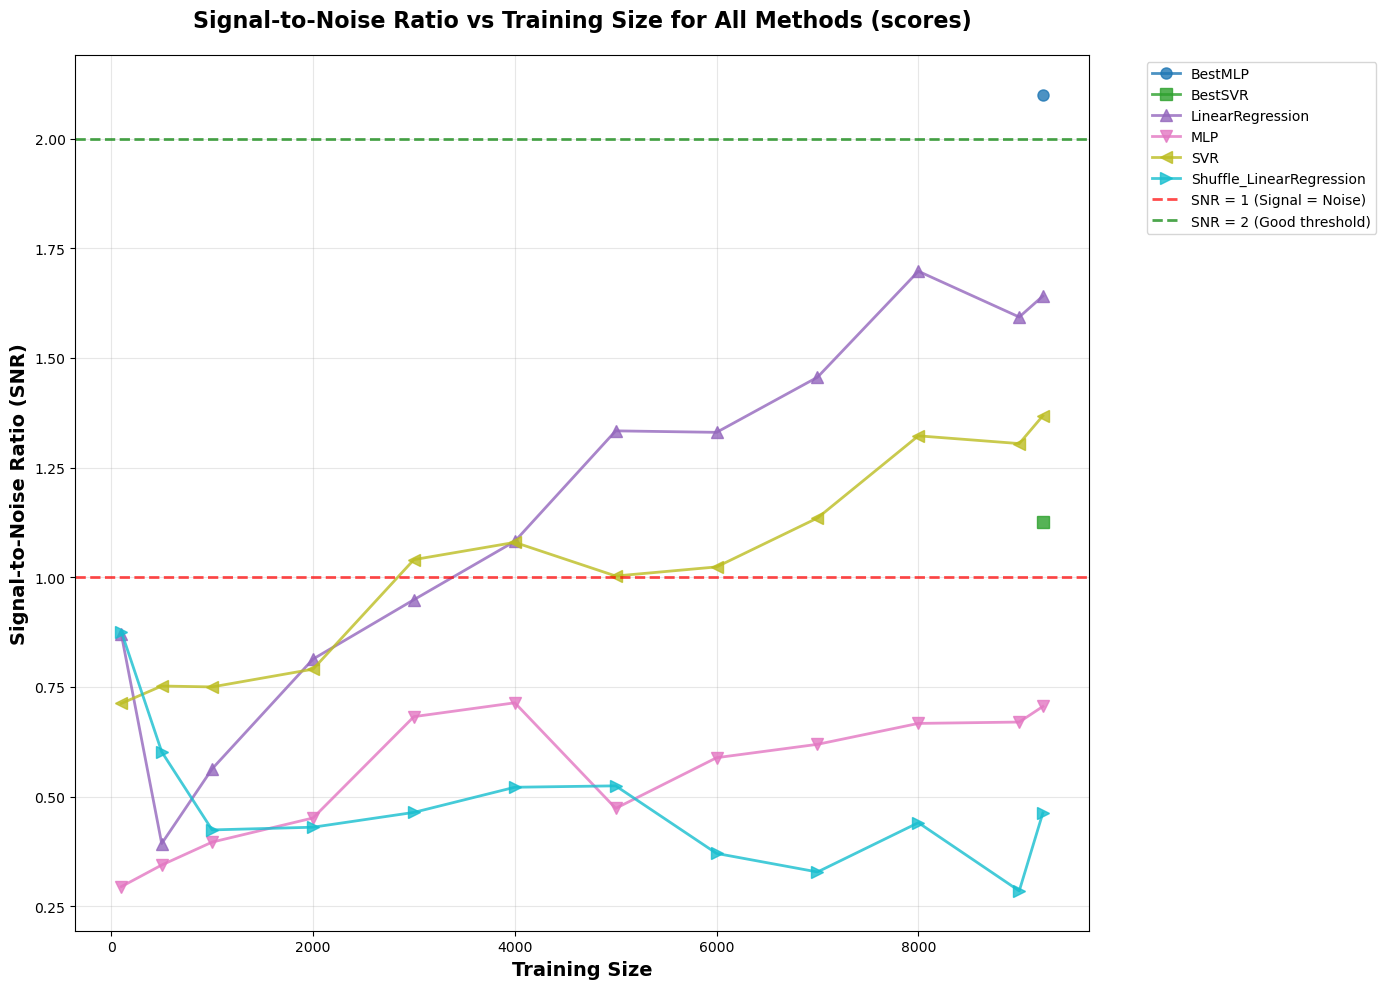


SNR SUMMARY STATISTICS (scores)
Overall SNR range: 0.285 to 2.101
Overall SNR mean: 0.831 ± 0.427

Methods with SNR > 2 (good performance):
  BestMLP: 1 training sizes

Methods with SNR < 1 (poor performance):
  LinearRegression: 5 training sizes
  Shuffle_LinearRegression: 12 training sizes
  SVR: 4 training sizes
  MLP: 12 training sizes

METHOD-WISE SNR SUMMARY:
----------------------------------------
                           mean    std    min    max  count
method_name                                                
BestMLP                   2.101    NaN  2.101  2.101      1
BestSVR                   1.126    NaN  1.126  1.126      1
LinearRegression          1.144  0.432  0.393  1.698     12
MLP                       0.550  0.151  0.295  0.714     12
SVR                       1.024  0.234  0.712  1.368     12
Shuffle_LinearRegression  0.477  0.153  0.285  0.876     12

TRAINING SIZE EFFECT ANALYSIS:
----------------------------------------
                mean    std    min   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

# Your existing data loading code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

# Filter for specific conditions but keep all methods (excluding BestSVR and BestMLP)
mask = ((df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal"))

df = df[mask]

def calculate_snr_scores(df_subset):
    """Calculate SNR for 'scores' (not raw_scores) for a given subset of data"""
    
    # Create exploded data using 'scores' and 'scores_std'
    df_exploded = df_subset.explode(['true_distances', 'scores', 'scores_std'])
    df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
    df_exploded['scores'] = pd.to_numeric(df_exploded['scores'])
    df_exploded['scores_std'] = pd.to_numeric(df_exploded['scores_std'])
    
    # Calculate aggregate statistics per true_distance
    agg_stats = df_exploded.groupby('true_distances').agg({
        'scores': 'mean',
        'scores_std': 'mean'
    }).round(6)
    
    agg_stats.columns = ['mean_score', 'mean_std']
    agg_stats = agg_stats.reset_index()
    
    # Signal-to-Noise Ratio
    signal_range = agg_stats['mean_score'].max() - agg_stats['mean_score'].min()
    mean_noise = agg_stats['mean_std'].mean()
    snr = signal_range / mean_noise if mean_noise > 0 else np.nan
    
    return snr

# Get all unique combinations of method_name and training_size
method_training_combinations = df[['method_name', 'training_size']].drop_duplicates()

# Calculate SNR for each combination
snr_results = []

print("Calculating SNR for 'scores' (not raw_scores) for all method-training size combinations...")

for _, row in method_training_combinations.iterrows():
    method_name = row['method_name']
    training_size = row['training_size']
    
    df_filtered = df[(df['method_name'] == method_name) & 
                     (df['training_size'] == training_size)]
    
    if len(df_filtered) > 0:
        try:
            snr = calculate_snr_scores(df_filtered)
            snr_results.append({
                'method_name': method_name,
                'training_size': training_size,
                'snr': snr
            })
        except Exception as e:
            print(f"Error calculating SNR for {method_name}, training_size {training_size}: {e}")

# Convert to DataFrame
snr_df = pd.DataFrame(snr_results)

# Remove any NaN values
snr_df = snr_df.dropna(subset=['snr'])

print(f"Successfully calculated SNR for {len(snr_df)} method-training size combinations")
print(f"Methods included: {sorted(snr_df['method_name'].unique())}")
print(f"Training sizes included: {sorted(snr_df['training_size'].unique())}")

# Create the plot
plt.figure(figsize=(14, 10))

# Get unique methods for color mapping
unique_methods = sorted(snr_df['method_name'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_methods)))

# Plot each method with a different color and marker
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', '+', 'x']
for i, method in enumerate(unique_methods):
    method_data = snr_df[snr_df['method_name'] == method]
    
    # Sort by training_size to ensure proper line connection
    method_data = method_data.sort_values('training_size')
    
    plt.plot(method_data['training_size'], method_data['snr'], 
             marker=markers[i % len(markers)], 
             color=colors[i],
             linewidth=2, 
             markersize=8,
             label=method,
             alpha=0.8)

# Customize the plot
plt.xlabel('Training Size', fontsize=14, fontweight='bold')
plt.ylabel('Signal-to-Noise Ratio (SNR)', fontsize=14, fontweight='bold')
plt.title('Signal-to-Noise Ratio vs Training Size for All Methods (scores)', 
          fontsize=16, fontweight='bold', pad=20)

# Add horizontal line at SNR = 1 for reference
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 1 (Signal = Noise)')

# Add horizontal line at SNR = 2 for "good" threshold
plt.axhline(y=2, color='green', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 2 (Good threshold)')

# Keep training size on linear scale
# (log scale removed as requested)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Position legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SNR SUMMARY STATISTICS (scores)")
print("="*60)

print(f"Overall SNR range: {snr_df['snr'].min():.3f} to {snr_df['snr'].max():.3f}")
print(f"Overall SNR mean: {snr_df['snr'].mean():.3f} ± {snr_df['snr'].std():.3f}")

print(f"\nMethods with SNR > 2 (good performance):")
good_performance = snr_df[snr_df['snr'] > 2]
if len(good_performance) > 0:
    for method in good_performance['method_name'].unique():
        method_good = good_performance[good_performance['method_name'] == method]
        print(f"  {method}: {len(method_good)} training sizes")
else:
    print("  None")

print(f"\nMethods with SNR < 1 (poor performance):")
poor_performance = snr_df[snr_df['snr'] < 1]
if len(poor_performance) > 0:
    for method in poor_performance['method_name'].unique():
        method_poor = poor_performance[poor_performance['method_name'] == method]
        print(f"  {method}: {len(method_poor)} training sizes")
else:
    print("  None")

# Method-wise summary
print(f"\nMETHOD-WISE SNR SUMMARY:")
print("-" * 40)
method_summary = snr_df.groupby('method_name')['snr'].agg(['mean', 'std', 'min', 'max', 'count']).round(3)
print(method_summary.to_string())

# Training size effect analysis
print(f"\nTRAINING SIZE EFFECT ANALYSIS:")
print("-" * 40)
training_summary = snr_df.groupby('training_size')['snr'].agg(['mean', 'std', 'min', 'max', 'count']).round(3)
print(training_summary.to_string())

# Store results in variables for further analysis
print(f"\nResults stored in 'snr_df' DataFrame with {len(snr_df)} rows.")
print("Columns: method_name, training_size, snr")

# Compare with raw_scores results if available
print(f"\nNote: This analysis uses 'scores' and 'scores_std' instead of 'raw_scores' and 'raw_scores_std'.")

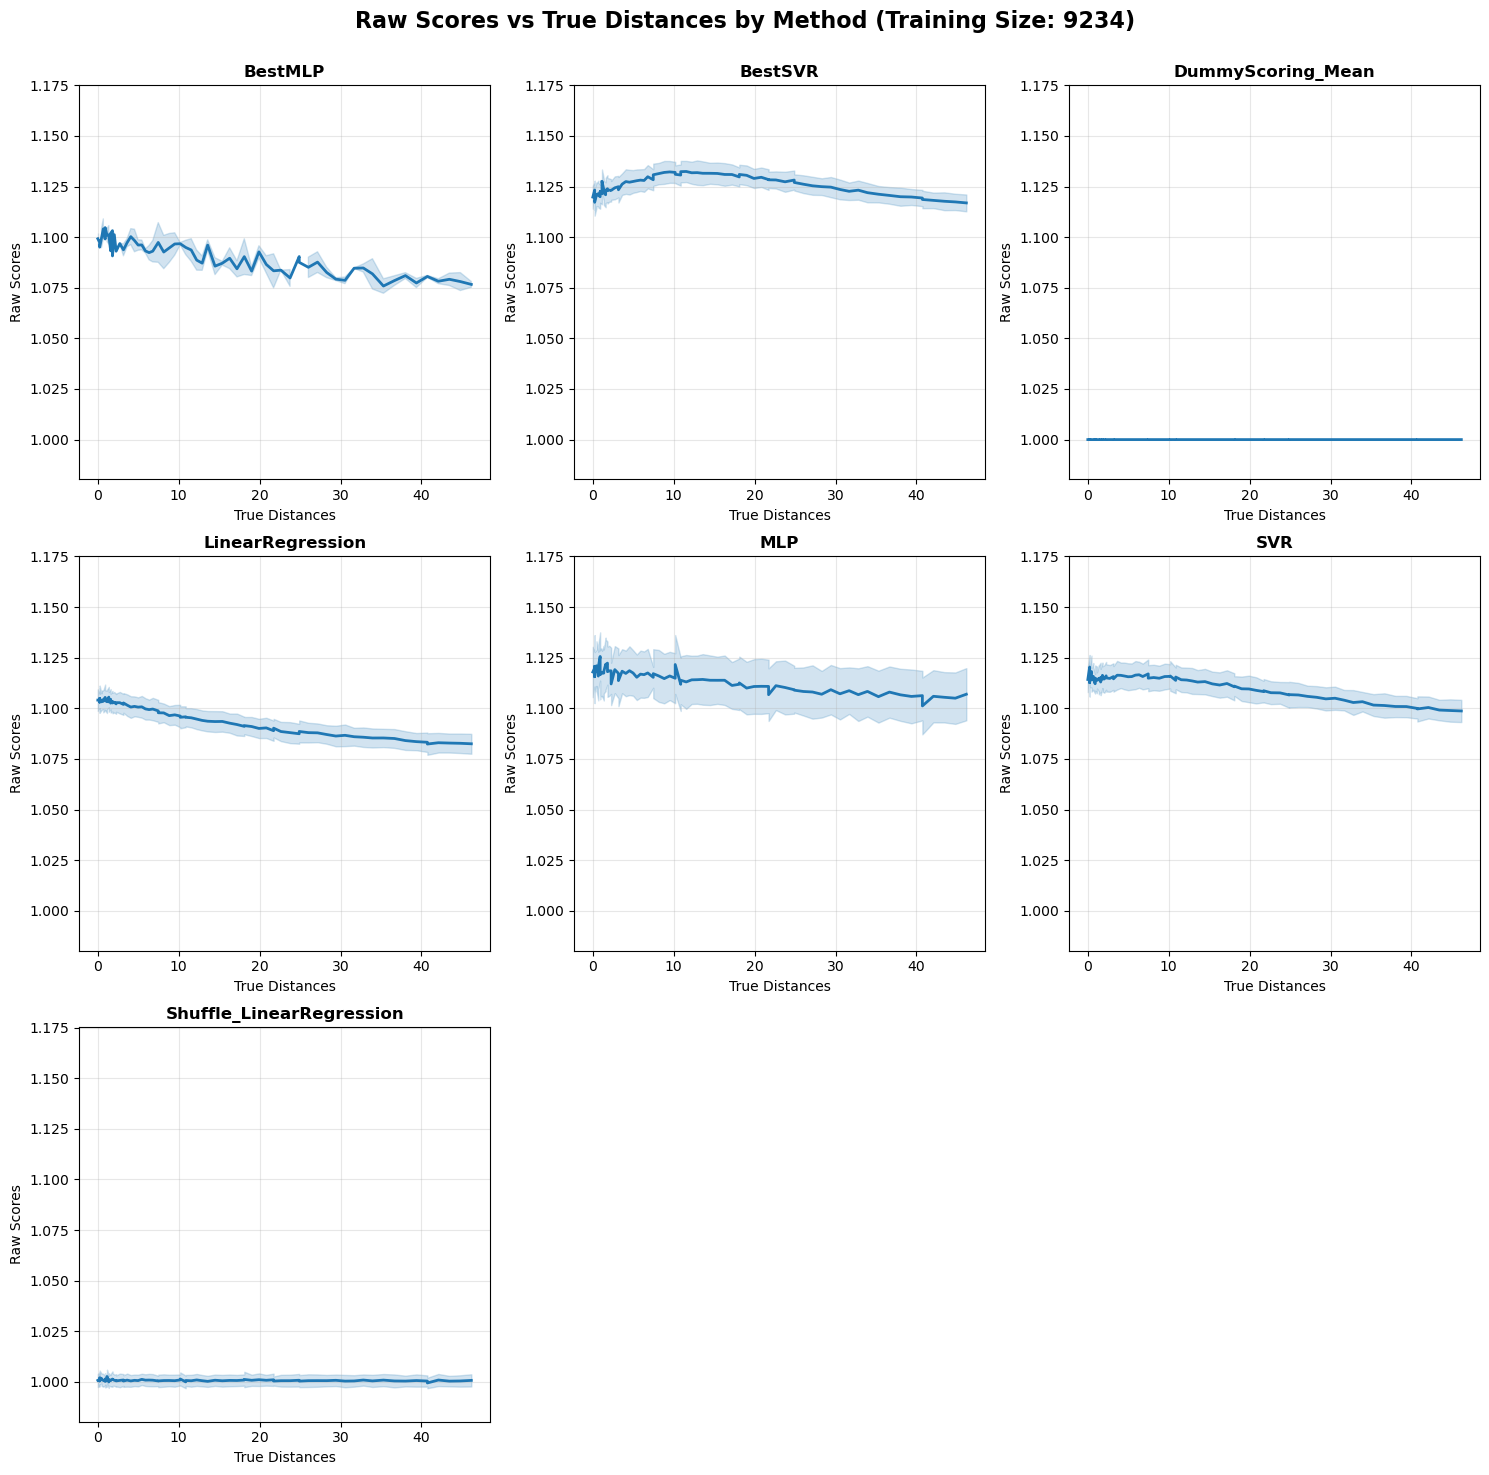

Created subplots for 7 methods:
  - BestMLP
  - BestSVR
  - DummyScoring_Mean
  - LinearRegression
  - MLP
  - SVR
  - Shuffle_LinearRegression
Y-axis range: 0.980 to 1.175


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "diagonal"))

df = df[mask]

# Filter for only training_size 9234
df_filtered = df[df['training_size'] == 9234]

# Get unique methods
unique_methods = sorted(df_filtered['method_name'].unique())
n_methods = len(unique_methods)

# Calculate subplot layout
n_cols = 3  # 3 columns
n_rows = int(np.ceil(n_methods / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# If only one row, make sure axes is a list
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_methods == 1:
    axes = np.array([[axes]])

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Focus on raw_scores metric
metric_name = 'scores'

# Find global y-axis limits by processing all data first
all_y_values = []
for method_name in unique_methods:
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    if len(method_data) > 0:
        df_exploded = method_data.explode(['true_distances', metric_name])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        all_y_values.extend(df_exploded[metric_name].dropna().tolist())

# Calculate global y-axis limits
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min_padded = y_min - 0.05 * y_range
    y_max_padded = y_max + 0.05 * y_range
else:
    y_min_padded, y_max_padded = 0, 1

for i, method_name in enumerate(unique_methods):
    # Filter data for this method
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    
    if len(method_data) > 0:
        # Create exploded data
        df_exploded = method_data.explode(['true_distances', metric_name])
        
        # Convert to numeric
        df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        
        # Create the line plot
        sns.lineplot(data=df_exploded, 
                     x='true_distances', 
                     y=metric_name, 
                     errorbar=('sd', 1),
                     linewidth=2,
                     ax=axes_flat[i])
        
        # Set title and labels
        axes_flat[i].set_title(f'{method_name}', fontsize=12, fontweight='bold')
        axes_flat[i].set_xlabel('True Distances', fontsize=10)
        axes_flat[i].set_ylabel('Raw Scores', fontsize=10)
        
        # Set the same y-axis limits for all subplots
        axes_flat[i].set_ylim(y_min_padded, y_max_padded)
        
        # Add grid for better readability
        axes_flat[i].grid(True, alpha=0.3)
    else:
        # If no data for this method, hide the subplot
        axes_flat[i].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# Set overall title
fig.suptitle(f'Raw Scores vs True Distances by Method (Training Size: 9234)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

print(f"Created subplots for {len(unique_methods)} methods:")
for method in unique_methods:
    print(f"  - {method}")
print(f"Y-axis range: {y_min_padded:.3f} to {y_max_padded:.3f}")

Calculating SNR for each individual row...
Successfully calculated SNR for 8008 out of 10048 rows
Methods included: ['LinearRegression', 'MLP', 'SVR', 'Shuffle_LinearRegression']
Training sizes included: [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9234]
Method-training size combinations with ≥2 runs: 48


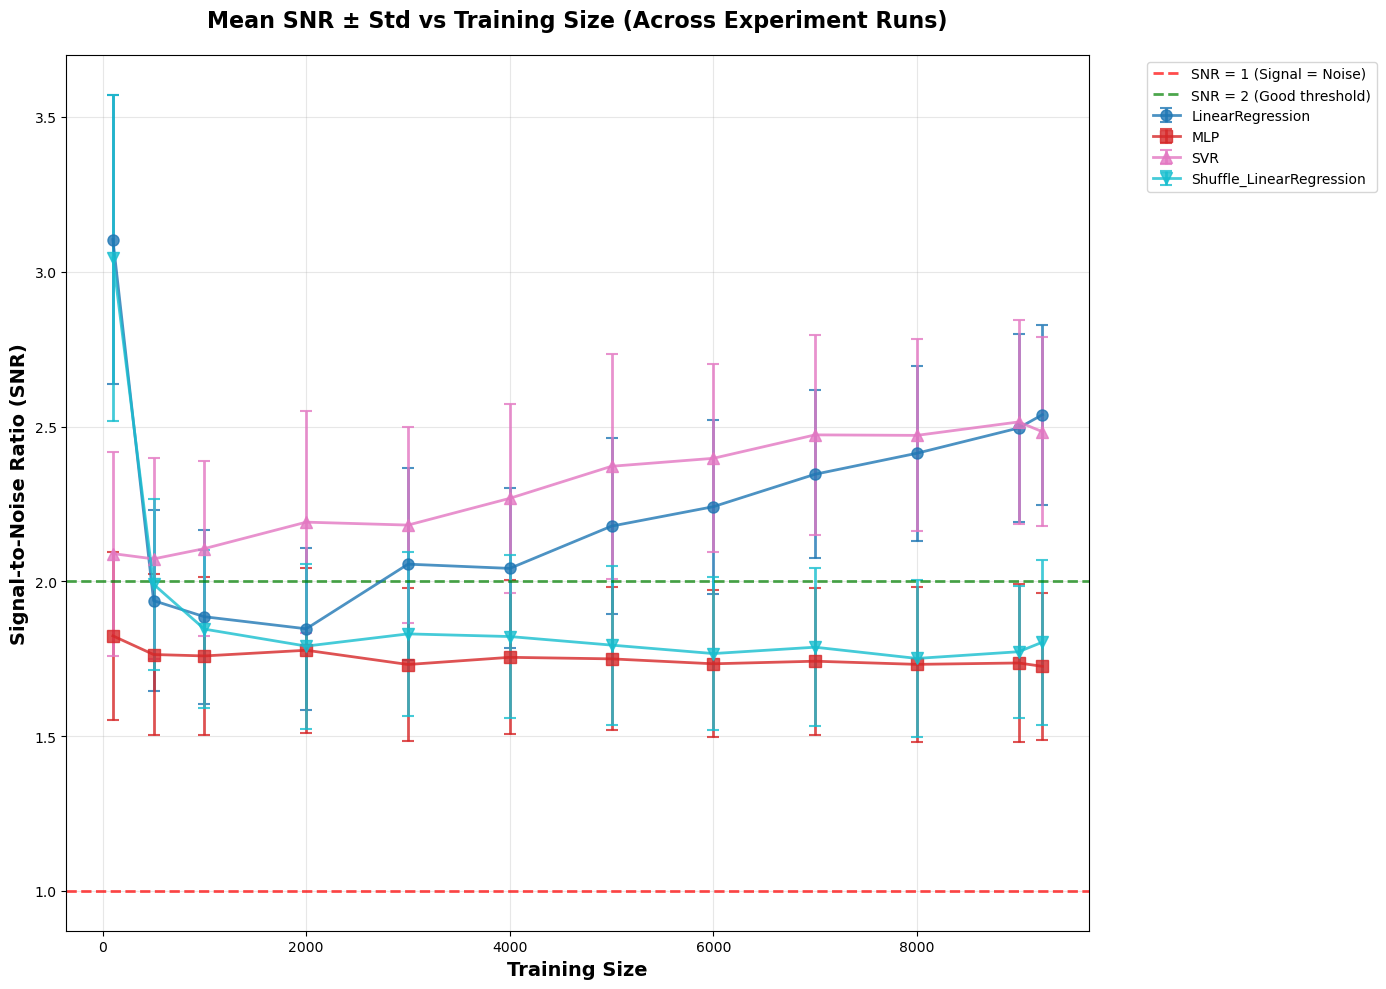


SNR SUMMARY STATISTICS (per-row calculation)
Overall SNR statistics across all individual runs:
  Range: 1.002 to 5.364
  Mean: 2.052 ± 0.451
  Total runs analyzed: 8008

METHOD-TRAINING SIZE COMBINATIONS SUMMARY:
--------------------------------------------------------------------------------
Method          Train_Size Mean_SNR   Std_SNR    N_Runs   95%_CI    
--------------------------------------------------------------------------------
LinearRegression 100        3.104      0.468      170      ±0.070    
LinearRegression 500        1.938      0.292      170      ±0.044    
LinearRegression 1000       1.886      0.281      170      ±0.042    
LinearRegression 2000       1.847      0.262      170      ±0.039    
LinearRegression 3000       2.055      0.310      170      ±0.047    
LinearRegression 4000       2.042      0.259      170      ±0.039    
LinearRegression 5000       2.178      0.284      170      ±0.043    
LinearRegression 6000       2.241      0.280      170      ±0.04

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

# Your existing data loading code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

# Filter for specific conditions but keep all methods (excluding BestSVR and BestMLP)
mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

def calculate_snr_single_row(row):
    """Calculate SNR for a single row (single experiment run)
    
    Note: scores and scores_std are already mean and std across runs for each true_distance,
    so no further aggregation is needed.
    """
    try:
        # Get the lists from this single row
        true_distances = row['true_distances']
        scores = row['scores']  # Already mean scores for each true_distance
        scores_std = row['scores_std']  # Already std of scores for each true_distance
        
        # Convert to numeric arrays
        true_distances = np.array([float(x) for x in true_distances])
        scores = np.array([float(x) for x in scores])
        scores_std = np.array([float(x) for x in scores_std])
        
        # Since scores and scores_std are already aggregated per true_distance,
        # we can directly calculate SNR without further grouping
        
        # Signal-to-Noise Ratio for this single row
        signal_range = scores.max() - scores.min()  # Range of mean scores across true_distances
        mean_noise = scores_std.mean()  # Average noise (std) across true_distances
        snr = signal_range / mean_noise if mean_noise > 0 else np.nan
        
        return snr
    except Exception as e:
        print(f"Error calculating SNR for row: {e}")
        return np.nan

print("Calculating SNR for each individual row...")

# Calculate SNR for each row
df['snr'] = df.apply(calculate_snr_single_row, axis=1)

# Remove rows where SNR calculation failed
df_valid = df.dropna(subset=['snr'])

print(f"Successfully calculated SNR for {len(df_valid)} out of {len(df)} rows")
print(f"Methods included: {sorted(df_valid['method_name'].unique())}")
print(f"Training sizes included: {sorted(df_valid['training_size'].unique())}")

# Now calculate mean and std SNR for each method-training size combination
snr_summary = df_valid.groupby(['method_name', 'training_size']).agg({
    'snr': ['mean', 'std', 'count']
}).round(6)

# Flatten column names
snr_summary.columns = ['snr_mean', 'snr_std', 'n_runs']
snr_summary = snr_summary.reset_index()

# Remove combinations with insufficient data (less than 2 runs)
snr_summary = snr_summary[snr_summary['n_runs'] >= 2]

print(f"Method-training size combinations with ≥2 runs: {len(snr_summary)}")

# Create the plot with error bars
plt.figure(figsize=(14, 10))

# Get unique methods for color mapping
unique_methods = sorted(snr_summary['method_name'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_methods)))

# Plot each method with error bars
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', '+', 'x']
for i, method in enumerate(unique_methods):
    method_data = snr_summary[snr_summary['method_name'] == method]
    
    # Sort by training_size to ensure proper line connection
    method_data = method_data.sort_values('training_size')
    
    # Plot with error bars
    plt.errorbar(method_data['training_size'], 
                 method_data['snr_mean'],
                 yerr=method_data['snr_std'],
                 marker=markers[i % len(markers)], 
                 color=colors[i],
                 linewidth=2, 
                 markersize=8,
                 capsize=4,
                 capthick=1.5,
                 label=method,
                 alpha=0.8)

# Customize the plot
plt.xlabel('Training Size', fontsize=14, fontweight='bold')
plt.ylabel('Signal-to-Noise Ratio (SNR)', fontsize=14, fontweight='bold')
plt.title('Mean SNR ± Std vs Training Size (Across Experiment Runs)', 
          fontsize=16, fontweight='bold', pad=20)

# Add horizontal line at SNR = 1 for reference
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 1 (Signal = Noise)')

# Add horizontal line at SNR = 2 for "good" threshold
plt.axhline(y=2, color='green', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 2 (Good threshold)')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Position legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

# Print detailed summary statistics
print("\n" + "="*80)
print("SNR SUMMARY STATISTICS (per-row calculation)")
print("="*80)

print(f"Overall SNR statistics across all individual runs:")
print(f"  Range: {df_valid['snr'].min():.3f} to {df_valid['snr'].max():.3f}")
print(f"  Mean: {df_valid['snr'].mean():.3f} ± {df_valid['snr'].std():.3f}")
print(f"  Total runs analyzed: {len(df_valid)}")

print(f"\nMETHOD-TRAINING SIZE COMBINATIONS SUMMARY:")
print("-" * 80)
print(f"{'Method':<15} {'Train_Size':<10} {'Mean_SNR':<10} {'Std_SNR':<10} {'N_Runs':<8} {'95%_CI':<10}")
print("-" * 80)

for _, row in snr_summary.iterrows():
    # Calculate 95% confidence interval
    se = row['snr_std'] / np.sqrt(row['n_runs'])  # Standard error
    ci_95 = 1.96 * se  # 95% CI
    
    print(f"{row['method_name']:<15} {int(row['training_size']):<10} "
          f"{row['snr_mean']:<10.3f} {row['snr_std']:<10.3f} "
          f"{int(row['n_runs']):<8} ±{ci_95:<9.3f}")

# Analysis by method
print(f"\nMETHOD-WISE ANALYSIS (averaging across training sizes):")
print("-" * 60)
method_analysis = snr_summary.groupby('method_name').agg({
    'snr_mean': ['mean', 'std'],
    'snr_std': 'mean',
    'n_runs': 'sum'
}).round(3)

method_analysis.columns = ['overall_mean_snr', 'std_of_means', 'avg_run_std', 'total_runs']
method_analysis = method_analysis.reset_index()

for _, row in method_analysis.iterrows():
    print(f"{row['method_name']:<15}: Mean SNR = {row['overall_mean_snr']:.3f} "
          f"(±{row['std_of_means']:.3f} across training sizes), "
          f"Avg within-condition std = {row['avg_run_std']:.3f}, "
          f"Total runs = {int(row['total_runs'])}")

# Analysis by training size
print(f"\nTRAINING SIZE ANALYSIS (averaging across methods):")
print("-" * 60)
training_analysis = snr_summary.groupby('training_size').agg({
    'snr_mean': ['mean', 'std'],
    'snr_std': 'mean',
    'n_runs': 'sum'
}).round(3)

training_analysis.columns = ['overall_mean_snr', 'std_of_means', 'avg_run_std', 'total_runs']
training_analysis = training_analysis.reset_index()

for _, row in training_analysis.iterrows():
    print(f"Training size {int(row['training_size']):<8}: Mean SNR = {row['overall_mean_snr']:.3f} "
          f"(±{row['std_of_means']:.3f} across methods), "
          f"Avg within-condition std = {row['avg_run_std']:.3f}, "
          f"Total runs = {int(row['total_runs'])}")

# Performance categories
print(f"\nPERFORMANCE CATEGORIES:")
print("-" * 40)

# High performance: mean SNR > 2
high_perf = snr_summary[snr_summary['snr_mean'] > 2]
print(f"High performance (Mean SNR > 2): {len(high_perf)} combinations")
for _, row in high_perf.iterrows():
    print(f"  {row['method_name']} @ {int(row['training_size'])}: {row['snr_mean']:.3f} ± {row['snr_std']:.3f}")

# Poor performance: mean SNR < 1
poor_perf = snr_summary[snr_summary['snr_mean'] < 1]
print(f"\nPoor performance (Mean SNR < 1): {len(poor_perf)} combinations")
for _, row in poor_perf.iterrows():
    print(f"  {row['method_name']} @ {int(row['training_size'])}: {row['snr_mean']:.3f} ± {row['snr_std']:.3f}")

# Correlation analysis
print(f"\nCORRELATION ANALYSIS:")
print("-" * 40)
correlation, p_value = stats.pearsonr(snr_summary['training_size'], snr_summary['snr_mean'])
print(f"Pearson correlation between training size and mean SNR: {correlation:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} correlation")

# Store results
print(f"\nStored results:")
print(f"- 'df_valid': DataFrame with {len(df_valid)} rows, each with individual SNR")
print(f"- 'snr_summary': DataFrame with {len(snr_summary)} method-training combinations with mean±std SNR")
print("- Individual run SNRs available in df_valid['snr']")
print("- Summary statistics in snr_summary: snr_mean, snr_std, n_runs")

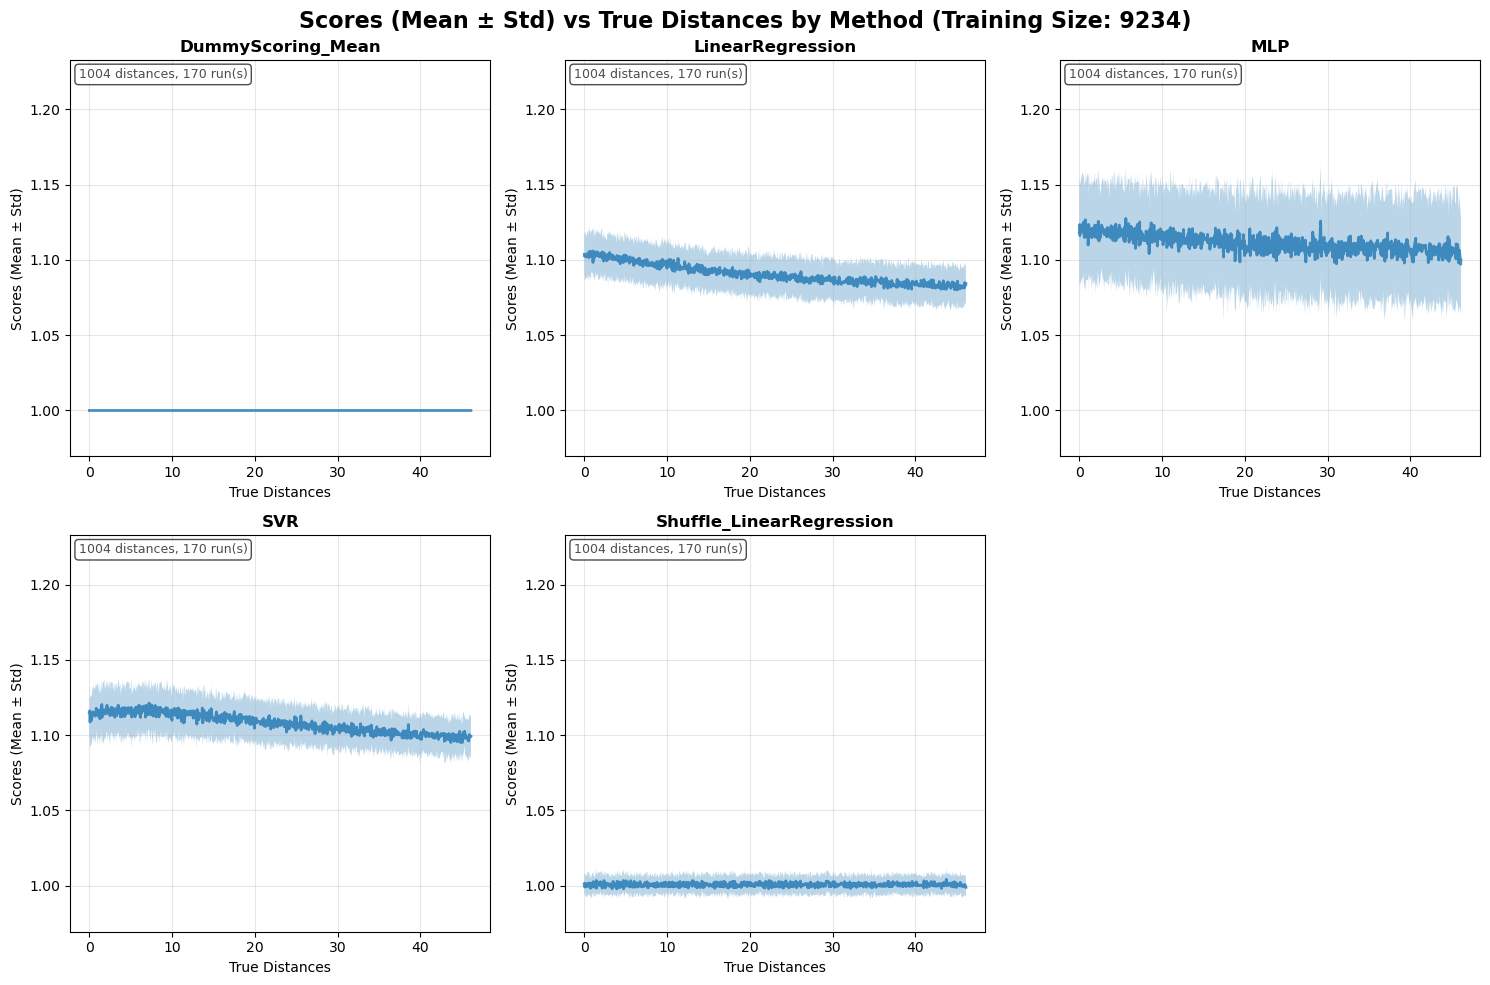

Created subplots for 5 methods:
  - DummyScoring_Mean: 170 run(s)
  - LinearRegression: 170 run(s)
  - MLP: 170 run(s)
  - SVR: 170 run(s)
  - Shuffle_LinearRegression: 170 run(s)
Y-axis range: 0.970 to 1.233

Note: Error bars represent the pre-calculated standard deviations from the original data,
not standard deviations calculated from exploded points.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

# Filter for only training_size 9234
df_filtered = df[df['training_size'] == 9234]

# Get unique methods
unique_methods = sorted(df_filtered['method_name'].unique())
n_methods = len(unique_methods)

# Calculate subplot layout
n_cols = 3  # 3 columns
n_rows = int(np.ceil(n_methods / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# If only one row, make sure axes is a list
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_methods == 1:
    axes = np.array([[axes]])

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Focus on scores metric
metric_name = 'scores'
metric_std_name = 'scores_std'

# Find global y-axis limits by processing all data first
all_y_values = []
all_y_errors = []

for method_name in unique_methods:
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    if len(method_data) > 0:
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Include error bars in y-axis calculation
        y_vals = df_exploded[metric_name].dropna()
        y_errs = df_exploded[metric_std_name].dropna()
        
        all_y_values.extend((y_vals - y_errs).tolist())  # Lower bounds
        all_y_values.extend((y_vals + y_errs).tolist())  # Upper bounds

# Calculate global y-axis limits
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min_padded = y_min - 0.05 * y_range
    y_max_padded = y_max + 0.05 * y_range
else:
    y_min_padded, y_max_padded = 0, 1

for i, method_name in enumerate(unique_methods):
    # Filter data for this method
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    
    if len(method_data) > 0:
        # Create exploded data including std
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        
        # Convert to numeric
        df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Group by true_distances to get mean and std for plotting
        # (in case there are multiple rows for the same method-training size combination)
        plot_data = df_exploded.groupby('true_distances').agg({
            metric_name: 'mean',
            metric_std_name: 'mean'  # Average the std if multiple rows
        }).reset_index()
        
        # Create the line plot with shaded area for std using the pre-calculated std
        axes_flat[i].plot(plot_data['true_distances'], 
                         plot_data[metric_name],
                         linewidth=2,
                         alpha=0.8)
        
        # Add shaded area for standard deviation
        axes_flat[i].fill_between(plot_data['true_distances'],
                                 plot_data[metric_name] - plot_data[metric_std_name],
                                 plot_data[metric_name] + plot_data[metric_std_name],
                                 alpha=0.3)
        
        # Set title and labels
        axes_flat[i].set_title(f'{method_name}', fontsize=12, fontweight='bold')
        axes_flat[i].set_xlabel('True Distances', fontsize=10)
        axes_flat[i].set_ylabel('Scores (Mean ± Std)', fontsize=10)
        
        # Set the same y-axis limits for all subplots
        axes_flat[i].set_ylim(y_min_padded, y_max_padded)
        
        # Add grid for better readability
        axes_flat[i].grid(True, alpha=0.3)
        
        # Add info about number of data points
        n_distances = len(plot_data)
        n_runs = len(method_data)
        axes_flat[i].text(0.02, 0.98, f'{n_distances} distances, {n_runs} run(s)', 
                         transform=axes_flat[i].transAxes, 
                         verticalalignment='top',
                         fontsize=9, alpha=0.7,
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    else:
        # If no data for this method, hide the subplot
        axes_flat[i].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# Set overall title
fig.suptitle(f'Scores (Mean ± Std) vs True Distances by Method (Training Size: 9234)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

print(f"Created subplots for {len(unique_methods)} methods:")
for method in unique_methods:
    n_runs = len(df_filtered[df_filtered['method_name'] == method])
    print(f"  - {method}: {n_runs} run(s)")
print(f"Y-axis range: {y_min_padded:.3f} to {y_max_padded:.3f}")

print("\nNote: Error bars represent the pre-calculated standard deviations from the original data,")
print("not standard deviations calculated from exploded points.")

In [ ]:
17*60

1020

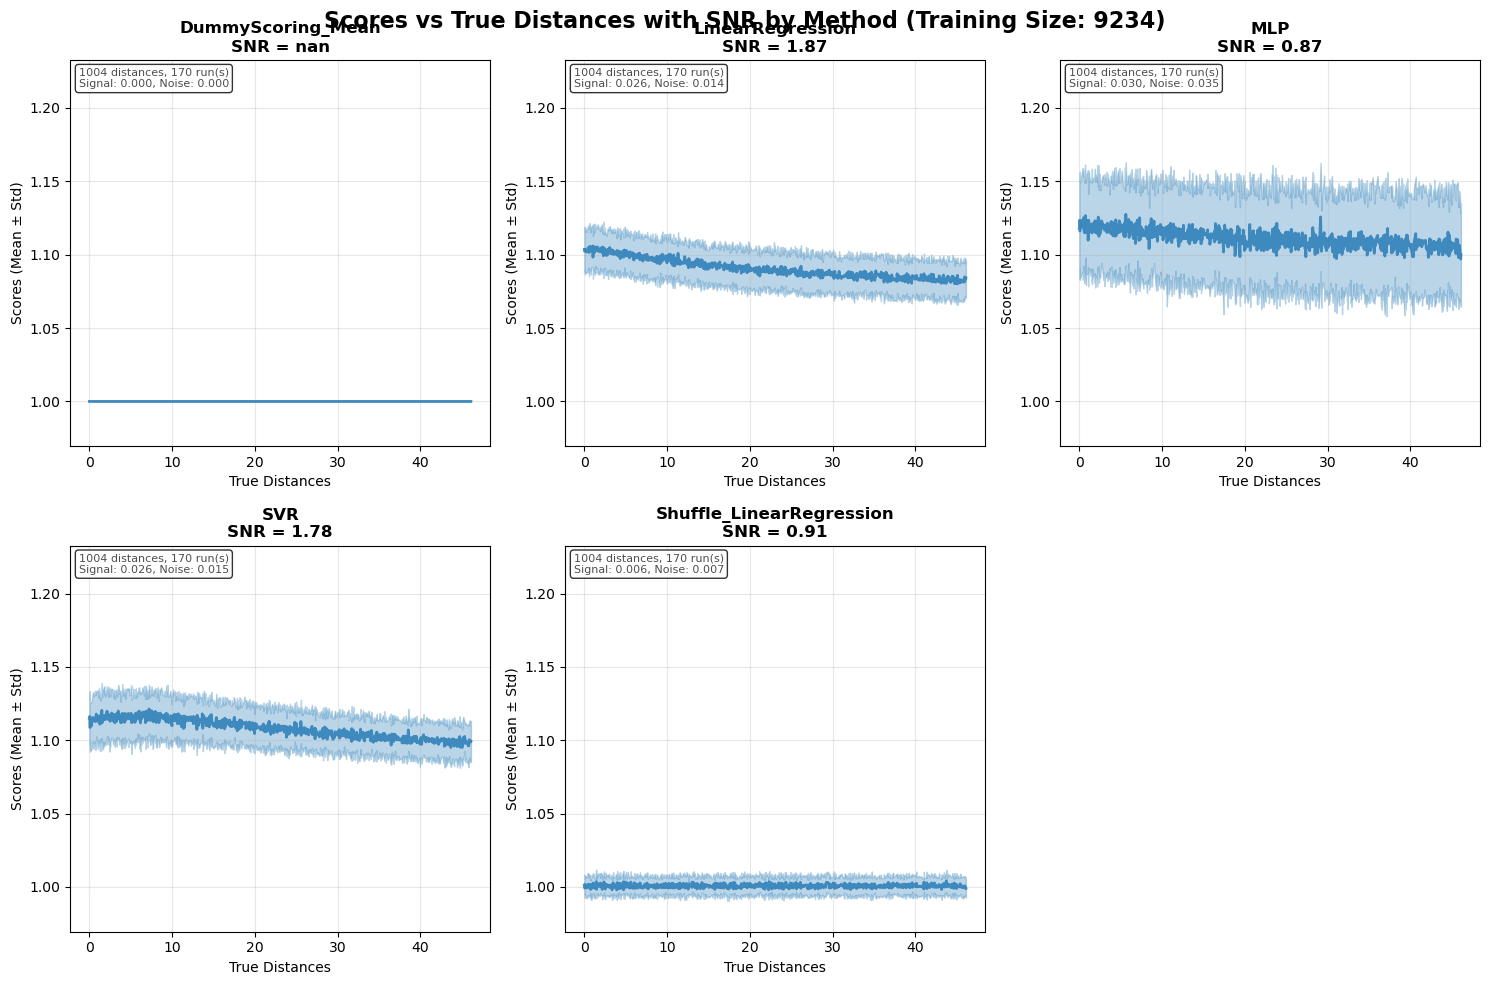

SNR SUMMARY FOR EACH METHOD (Training Size: 9234)
Method               SNR      Signal     Noise      Distances  Runs  
--------------------------------------------------------------------------------
LinearRegression     1.872    0.026      0.014      1004       170   
SVR                  1.783    0.026      0.015      1004       170   
Shuffle_LinearRegression 0.909    0.006      0.007      1004       170   
MLP                  0.866    0.030      0.035      1004       170   
DummyScoring_Mean    nan      0.000      0.000      1004       170   

SNR Statistics:
  Best SNR: 1.872 (LinearRegression)
  Worst SNR: 0.866 (MLP)
  Mean SNR: 1.357 ± 0.544
  Methods with SNR > 2: 0
  Methods with SNR > 1: 2
  Methods with SNR < 1: 2

PERFORMANCE CATEGORIES:
----------------------------------------
HIGH PERFORMANCE (SNR > 2): None

GOOD PERFORMANCE (1 < SNR ≤ 2):
  LinearRegression: SNR = 1.872
  SVR: SNR = 1.783

POOR PERFORMANCE (SNR ≤ 1):
  Shuffle_LinearRegression: SNR = 0.909
  MLP: SNR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

# Filter for only training_size 9234
df_filtered = df[df['training_size'] == 9234]

# Get unique methods
unique_methods = sorted(df_filtered['method_name'].unique())
n_methods = len(unique_methods)

# Calculate subplot layout
n_cols = 3  # 3 columns
n_rows = int(np.ceil(n_methods / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# If only one row, make sure axes is a list
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_methods == 1:
    axes = np.array([[axes]])

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Focus on scores metric
metric_name = 'scores'
metric_std_name = 'scores_std'

# Store SNR calculations
snr_results = []

# Find global y-axis limits by processing all data first
all_y_values = []

for method_name in unique_methods:
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    if len(method_data) > 0:
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Include error bars in y-axis calculation
        y_vals = df_exploded[metric_name].dropna()
        y_errs = df_exploded[metric_std_name].dropna()
        
        all_y_values.extend((y_vals - y_errs).tolist())  # Lower bounds
        all_y_values.extend((y_vals + y_errs).tolist())  # Upper bounds

# Calculate global y-axis limits
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min_padded = y_min - 0.05 * y_range
    y_max_padded = y_max + 0.05 * y_range
else:
    y_min_padded, y_max_padded = 0, 1

for i, method_name in enumerate(unique_methods):
    # Filter data for this method
    method_data = df_filtered[df_filtered['method_name'] == method_name]
    
    if len(method_data) > 0:
        # Create exploded data including std
        df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
        
        # Convert to numeric
        df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
        df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
        df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
        
        # Group by true_distances to get mean and std for plotting
        # (in case there are multiple rows for the same method-training size combination)
        plot_data = df_exploded.groupby('true_distances').agg({
            metric_name: 'mean',
            metric_std_name: 'mean'  # Average the std if multiple rows
        }).reset_index()
        
        # Calculate SNR for this method
        signal_range = plot_data[metric_name].max() - plot_data[metric_name].min()
        mean_noise = plot_data[metric_std_name].mean()
        snr = signal_range / mean_noise if mean_noise > 0 else np.nan
        
        # Store SNR result
        snr_results.append({
            'method_name': method_name,
            'snr': snr,
            'signal_range': signal_range,
            'mean_noise': mean_noise,
            'n_distances': len(plot_data),
            'n_runs': len(method_data)
        })
        
        # Create the line plot with shaded area for std using the pre-calculated std
        line = axes_flat[i].plot(plot_data['true_distances'], 
                                plot_data[metric_name],
                                linewidth=2,
                                alpha=0.8)
        
        # Add shaded area for standard deviation (same color as line)
        axes_flat[i].fill_between(plot_data['true_distances'],
                                 plot_data[metric_name] - plot_data[metric_std_name],
                                 plot_data[metric_name] + plot_data[metric_std_name],
                                 alpha=0.3,
                                 color=line[0].get_color())
        
        # Set title and labels with SNR
        axes_flat[i].set_title(f'{method_name}\nSNR = {snr:.2f}', fontsize=12, fontweight='bold')
        axes_flat[i].set_xlabel('True Distances', fontsize=10)
        axes_flat[i].set_ylabel('Scores (Mean ± Std)', fontsize=10)
        
        # Set the same y-axis limits for all subplots
        axes_flat[i].set_ylim(y_min_padded, y_max_padded)
        
        # Add grid for better readability
        axes_flat[i].grid(True, alpha=0.3)
        
        # Add info about number of data points and SNR components
        info_text = (f'{len(plot_data)} distances, {len(method_data)} run(s)\n'
                    f'Signal: {signal_range:.3f}, Noise: {mean_noise:.3f}')
        axes_flat[i].text(0.02, 0.98, info_text, 
                         transform=axes_flat[i].transAxes, 
                         verticalalignment='top',
                         fontsize=8, alpha=0.7,
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # If no data for this method, hide the subplot
        axes_flat[i].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# Set overall title
fig.suptitle(f'Scores vs True Distances with SNR by Method (Training Size: 9234)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for the main title
plt.show()

# Create SNR summary
snr_df = pd.DataFrame(snr_results)
snr_df = snr_df.sort_values('snr', ascending=False)

print("="*80)
print("SNR SUMMARY FOR EACH METHOD (Training Size: 9234)")
print("="*80)
print(f"{'Method':<20} {'SNR':<8} {'Signal':<10} {'Noise':<10} {'Distances':<10} {'Runs':<6}")
print("-"*80)

for _, row in snr_df.iterrows():
    print(f"{row['method_name']:<20} {row['snr']:<8.3f} {row['signal_range']:<10.3f} "
          f"{row['mean_noise']:<10.3f} {int(row['n_distances']):<10} {int(row['n_runs']):<6}")

print(f"\nSNR Statistics:")
print(f"  Best SNR: {snr_df['snr'].max():.3f} ({snr_df.loc[snr_df['snr'].idxmax(), 'method_name']})")
print(f"  Worst SNR: {snr_df['snr'].min():.3f} ({snr_df.loc[snr_df['snr'].idxmin(), 'method_name']})")
print(f"  Mean SNR: {snr_df['snr'].mean():.3f} ± {snr_df['snr'].std():.3f}")
print(f"  Methods with SNR > 2: {len(snr_df[snr_df['snr'] > 2])}")
print(f"  Methods with SNR > 1: {len(snr_df[snr_df['snr'] > 1])}")
print(f"  Methods with SNR < 1: {len(snr_df[snr_df['snr'] < 1])}")

# Performance categories
print(f"\nPERFORMANCE CATEGORIES:")
print("-" * 40)

high_performance = snr_df[snr_df['snr'] > 2]
if len(high_performance) > 0:
    print(f"HIGH PERFORMANCE (SNR > 2):")
    for _, row in high_performance.iterrows():
        print(f"  {row['method_name']}: SNR = {row['snr']:.3f}")
else:
    print("HIGH PERFORMANCE (SNR > 2): None")

good_performance = snr_df[(snr_df['snr'] > 1) & (snr_df['snr'] <= 2)]
if len(good_performance) > 0:
    print(f"\nGOOD PERFORMANCE (1 < SNR ≤ 2):")
    for _, row in good_performance.iterrows():
        print(f"  {row['method_name']}: SNR = {row['snr']:.3f}")
else:
    print("\nGOOD PERFORMANCE (1 < SNR ≤ 2): None")

poor_performance = snr_df[snr_df['snr'] <= 1]
if len(poor_performance) > 0:
    print(f"\nPOOR PERFORMANCE (SNR ≤ 1):")
    for _, row in poor_performance.iterrows():
        print(f"  {row['method_name']}: SNR = {row['snr']:.3f}")
else:
    print("\nPOOR PERFORMANCE (SNR ≤ 1): None")

print(f"\nNote: SNR = Signal Range / Mean Noise")
print(f"      Signal Range = max(mean_scores) - min(mean_scores) across true distances")
print(f"      Mean Noise = average of std_scores across true distances")

Analyzing 5 methods across 12 training sizes
Methods: ['DummyScoring_Mean', 'LinearRegression', 'MLP', 'SVR', 'Shuffle_LinearRegression']
Training sizes: [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9234]

Calculating SNR for all method-training size combinations...
Successfully calculated SNR for 48 method-training size combinations


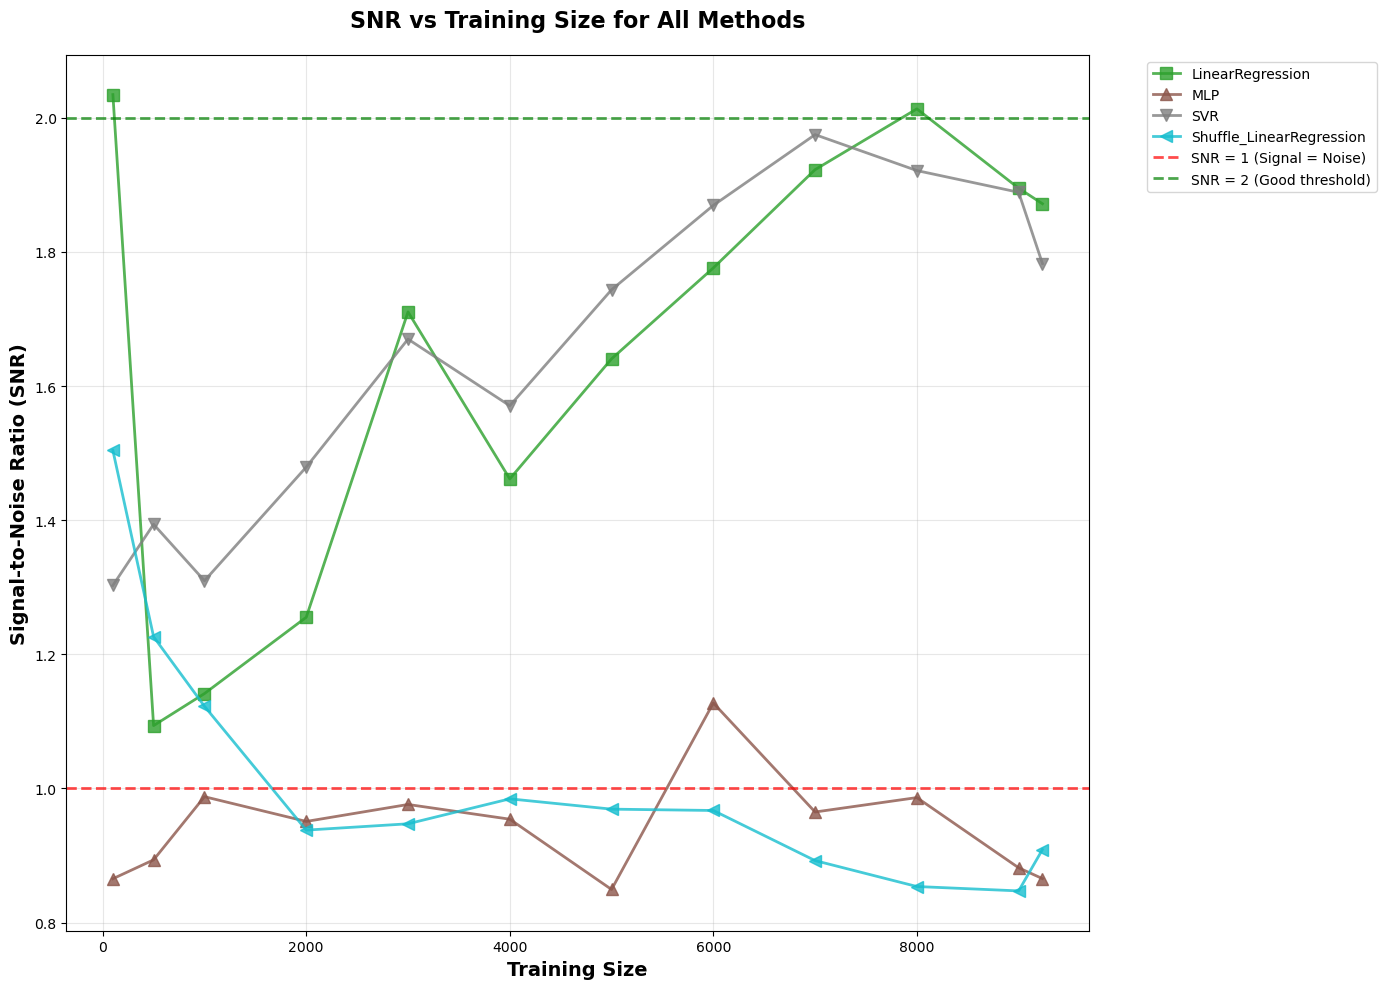

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

# Get all unique combinations of method and training size
unique_methods = sorted(df['method_name'].unique())
unique_training_sizes = sorted(df['training_size'].unique())

print(f"Analyzing {len(unique_methods)} methods across {len(unique_training_sizes)} training sizes")
print(f"Methods: {unique_methods}")
print(f"Training sizes: {unique_training_sizes}")

# Focus on scores metric
metric_name = 'scores'
metric_std_name = 'scores_std'

# Calculate SNR for all method-training size combinations
snr_results = []

print("\nCalculating SNR for all method-training size combinations...")

for method_name in unique_methods:
    for training_size in unique_training_sizes:
        # Filter data for this method and training size
        method_data = df[(df['method_name'] == method_name) & 
                        (df['training_size'] == training_size)]
        
        if len(method_data) > 0:
            try:
                # Create exploded data including std
                df_exploded = method_data.explode(['true_distances', metric_name, metric_std_name])
                
                # Convert to numeric
                df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
                df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
                df_exploded[metric_std_name] = pd.to_numeric(df_exploded[metric_std_name])
                
                # Group by true_distances to get mean and std for plotting
                plot_data = df_exploded.groupby('true_distances').agg({
                    metric_name: 'mean',
                    metric_std_name: 'mean'  # Average the std if multiple rows
                }).reset_index()
                
                # Calculate SNR for this method-training size combination
                signal_range = plot_data[metric_name].max() - plot_data[metric_name].min()
                mean_noise = plot_data[metric_std_name].mean()
                snr = signal_range / mean_noise if mean_noise > 0 else np.nan
                
                # Store SNR result
                snr_results.append({
                    'method_name': method_name,
                    'training_size': training_size,
                    'snr': snr,
                    'signal_range': signal_range,
                    'mean_noise': mean_noise,
                    'n_distances': len(plot_data),
                    'n_runs': len(method_data)
                })
                
            except Exception as e:
                print(f"Error processing {method_name} with training size {training_size}: {e}")

# Create DataFrame
snr_df = pd.DataFrame(snr_results)
snr_df = snr_df.dropna(subset=['snr'])

print(f"Successfully calculated SNR for {len(snr_df)} method-training size combinations")

# Create the SNR vs Training Size plot
plt.figure(figsize=(14, 10))

# Get unique methods for color mapping
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_methods)))
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', '+', 'x']

# Plot each method with a different color and marker
for i, method in enumerate(unique_methods):
    method_data = snr_df[snr_df['method_name'] == method]
    
    if len(method_data) > 0:
        # Sort by training_size to ensure proper line connection
        method_data = method_data.sort_values('training_size')
        
        plt.plot(method_data['training_size'], method_data['snr'], 
                 marker=markers[i % len(markers)], 
                 color=colors[i],
                 linewidth=2, 
                 markersize=8,
                 label=method,
                 alpha=0.8)

# Customize the plot
plt.xlabel('Training Size', fontsize=14, fontweight='bold')
plt.ylabel('Signal-to-Noise Ratio (SNR)', fontsize=14, fontweight='bold')
plt.title('SNR vs Training Size for All Methods', 
          fontsize=16, fontweight='bold', pad=20)

# Add horizontal reference lines
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 1 (Signal = Noise)')
plt.axhline(y=2, color='green', linestyle='--', alpha=0.7, linewidth=2, 
            label='SNR = 2 (Good threshold)')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Position legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()


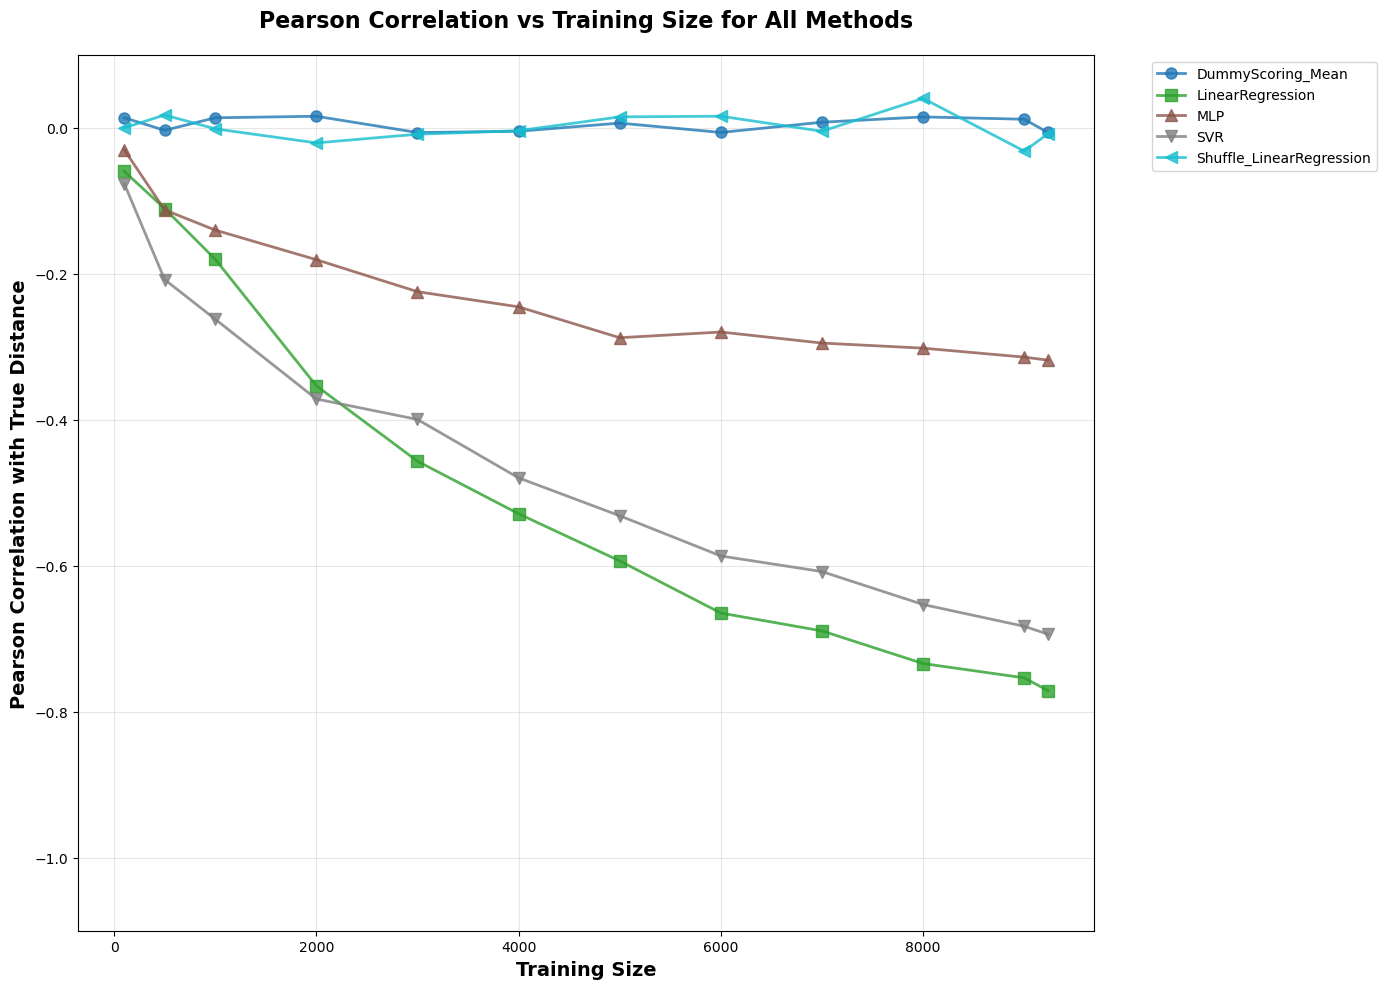

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy import stats

# Your existing data loading and filtering code
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]

# Get all unique combinations of method and training size
unique_methods = sorted(df['method_name'].unique())
unique_training_sizes = sorted(df['training_size'].unique())

# Focus on scores metric
metric_name = 'scores'

# Calculate Pearson correlation for all method-training size combinations
correlation_results = []

for method_name in unique_methods:
    for training_size in unique_training_sizes:
        # Filter data for this method and training size
        method_data = df[(df['method_name'] == method_name) & 
                        (df['training_size'] == training_size)]
        
        if len(method_data) > 0:
            try:
                # Create exploded data
                df_exploded = method_data.explode(['true_distances', metric_name])
                
                # Convert to numeric
                df_exploded['true_distances'] = pd.to_numeric(df_exploded['true_distances'])
                df_exploded[metric_name] = pd.to_numeric(df_exploded[metric_name])
                
                # Remove any NaN values
                df_clean = df_exploded.dropna(subset=['true_distances', metric_name])
                
                if len(df_clean) >= 3:  # Need at least 3 points for correlation
                    # Calculate Pearson correlation between true_distances and scores
                    correlation, p_value = stats.pearsonr(df_clean['true_distances'], 
                                                         df_clean[metric_name])
                    
                    # Store correlation result
                    correlation_results.append({
                        'method_name': method_name,
                        'training_size': training_size,
                        'correlation': correlation,
                        'p_value': p_value,
                        'n_points': len(df_clean),
                        'n_runs': len(method_data)
                    })
                
            except Exception as e:
                pass  # Skip problematic combinations

# Create DataFrame
corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.dropna(subset=['correlation'])

# Create the Correlation vs Training Size plot
plt.figure(figsize=(14, 10))

# Get unique methods for color mapping
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_methods)))
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', '+', 'x']

# Plot each method with a different color and marker
for i, method in enumerate(unique_methods):
    method_data = corr_df[corr_df['method_name'] == method]
    
    if len(method_data) > 0:
        # Sort by training_size to ensure proper line connection
        method_data = method_data.sort_values('training_size')
        
        plt.plot(method_data['training_size'], method_data['correlation'], 
                 marker=markers[i % len(markers)], 
                 color=colors[i],
                 linewidth=2, 
                 markersize=8,
                 label=method,
                 alpha=0.8)

# Customize the plot
plt.xlabel('Training Size', fontsize=14, fontweight='bold')
plt.ylabel('Pearson Correlation with True Distance', fontsize=14, fontweight='bold')
plt.title('Pearson Correlation vs Training Size for All Methods', 
          fontsize=16, fontweight='bold', pad=20)


# Set y-axis limits
plt.ylim(-1.1, 0.1)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Position legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()